## *Are there synergies and trade-offs in sustainable heating from cleaner stoves and home insulation?*  
## Evidence from air pollution control policies in southern Chile
**Version:** 11.11.2025

## New Model: 2×2 interaction model with fixed effects. ON Effect on Indoor PM by Treatment Group

**Equation:**

$$
\ln(PMi_{it}) = \beta_1 ON_{it} + \beta_2 (ON_{it}\times PELLET_i) + \beta_3 (ON_{it} \times INSULATION_i) + \beta_4 (ON_{it}  \times PELLET_i \times INSULATION_i) + \gamma_1 \ln(PMo_{it}) + \gamma_2 \ln(To_{it}) + \gamma_3 SecondStove_{it} + \mu_i + \tau_h + \delta_d + \varepsilon_{it}
$$

**Where:**
- **LnPMi** → log of indoor particulate matter concentration  
- **ON** → indicator for stove operational status (1 = stove ON, 0 = OFF)  
- **PELLET** → pellet stove treatment indicator  
- **INSULATION** → insulation treatment indicator  
- **ON×PELLET**, **ON×INSULATION**, **ON×PELLET×INSULATION** → interaction terms capturing heterogeneity in the ON effect across treatment groups  
- **LnPMo** → log of outdoor particulate matter concentration (control for ambient conditions)  
- **LnTo** → log of outdoor temperature (control for weather conditions)
- **SecondStove** → indicator for second stove operational status (1 = Second Stove ON, 0 = OFF)  
- **μ_i** → individual (household) fixed effects  
- **τ_h** → hourly fixed effects  
- **δ_d** → experimental day fixed effects  
- **ε_it** → idiosyncratic error term  

*Cluster-robust standard errors applied at the ID level. Fixed effects: ID (individual), Hour (temporal), DayExp (experimental day)*

## Causal Identification Strategy
Our analysis employs **Weighted Least Squares (WLS) Fixed Effects (FE) regression** with **Multinomial Generalized Propensity Score (GPS) Weights** incorporating covariate interactions to balance observed characteristics across treatment groups (Lopez & Gutman, 2017). We address selection bias from both subsidy programs simultaneously. Unlike separate binary matchings, we use a unified approach that models selection into all four treatment combinations using the same set of socioeconomic and housing characteristics—including income proxies, education, family composition, dwelling age, and construction materials—ensuring consistent balancing across all comparisons (Imbens, 2000). This single multinomial specification with stabilized weights (Robins et al., 2000) creates comparable groups for all treatment combinations while maintaining the sample's representativeness through common support restrictions.

## Interpretation:
The interaction terms allow us to estimate how the ON effect (i.e., the change in indoor PM when the stove is operating) varies across treatment combinations:
**Baseline (Firewood, No Insulation):** The ON effect is captured by **β₁**, representing the change in indoor PM concentration when the firewood stove is ON relative to OFF.
**Pellet-only Households:** The ON effect equals **β₁ + β₂**, indicating how the switch to a pellet stove modifies the ON effect compared to the baseline.
**Insulation-only Households:** The ON effect equals **β₁ + β₃**, showing how improved insulation changes the stove-use effect on indoor PM relative to non-insulated homes.
**Pellet + Insulation Households:** The ON effect equals **β₁ + β₂ + β₃ + β₄**, capturing the combined influence of both clean heating and insulation improvements.

In [1]:
# Pre-treatment of our data

# === Setup ===
import warnings
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress the specific statsmodels warning
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels")

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# User settings
# -----------------------
FILE_PATH       = "Panel_03112025.xlsx"
SHEET_NAME      = "Covariates"
SEED            = 42  # reproducible imputation for gender
# -----------------------
# 0) Load data
# -----------------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
df_imputed = df.copy()
# Track which rows were imputed (booleans)
df_imputed["imputed_Age"]       = False
df_imputed["imputed_Education"] = False
df_imputed["imputed_Gender"]    = False
# =======================
# 1) AGE: median within Anypersonolder60 groups (0/1)
# =======================
#print("\n=== AGE IMPUTATION ===")
age_medians = df_imputed.groupby("Anypersonolder60", dropna=False)["Age"].median()
#print("Median Age by Anypersonolder60:")
#print(age_medians, "\n")
for g, med in age_medians.items():
    mask = (df_imputed["Anypersonolder60"] == g) & (df_imputed["Age"].isna())
    df_imputed.loc[mask, "Age"] = med
    df_imputed.loc[mask, "imputed_Age"] = True
#print(f"✅ Remaining missing Ages: {df_imputed['Age'].isna().sum()}")
# =======================
# 2) EDUCATION: overall sample median (no grouping)
# =======================
#print("\n=== EDUCATION IMPUTATION ===")
edu_median_all = df_imputed["Education"].median()
#print(f"Overall median Education (full sample): {edu_median_all}\n")
mask_edu_miss = df_imputed["Education"].isna()
df_imputed.loc[mask_edu_miss, "Education"] = edu_median_all
df_imputed.loc[mask_edu_miss, "imputed_Education"] = True
#print(f"✅ Remaining missing Education values: {df_imputed['Education'].isna().sum()}")
# (Optional) If you want Education as integers, uncomment:
# df_imputed["Education"] = df_imputed["Education"].round().astype("Int64")
# =======================
# 3) GENDER: random draw using observed proportion of women (among non-missing)
# =======================
#print("\n=== GENDER IMPUTATION ===")
prop_women = df_imputed["GenderHHead1women"].mean(skipna=True)
#print(f"Observed share of women heads: {prop_women:.2%}")
mask_gender_miss = df_imputed["GenderHHead1women"].isna()
n_miss_gender = mask_gender_miss.sum()
#print(f"Missing GenderHHead1women values: {n_miss_gender}")
np.random.seed(SEED)
if n_miss_gender > 0:
    draws = np.random.binomial(1, prop_women, size=n_miss_gender)
    df_imputed.loc[mask_gender_miss, "GenderHHead1women"] = draws
    df_imputed.loc[mask_gender_miss, "imputed_Gender"] = True
#print(f"✅ Imputed {n_miss_gender} Gender values by random draws (p={prop_women:.3f}).")
#print("New share of women heads:",df_imputed["GenderHHead1women"].mean().round(3))
# =======================
# 4) Compact audit report
# =======================
print("\n=== IMPUTATION AUDIT SUMMARY ===")
audit = {
    "Age": {
        "imputed_n": int(df_imputed["imputed_Age"].sum()),
        "remaining_na": int(df_imputed["Age"].isna().sum())
    },
    "Education": {
        "imputed_n": int(df_imputed["imputed_Education"].sum()),
        "remaining_na": int(df_imputed["Education"].isna().sum())
    },
    "GenderHHead1women": {
        "imputed_n": int(df_imputed["imputed_Gender"].sum()),
        "remaining_na": int(df_imputed["GenderHHead1women"].isna().sum())
    }
}
for k, v in audit.items():
    print(f"{k:>18} → imputed: {v['imputed_n']:>3} NA of 379, remaining NA: {v['remaining_na']:>3}")
# -----------------------
# (Optional) save result
# -----------------------
# df_imputed.to_excel("Covariates_imputed.xlsx", index=False)

interaction_pairs = [
    ("FamilySize", "Chamber"),              # People × facility
    ("FamilySize", "Perc_concrete_built"),  # People × building
    ("Chamber", "Perc_concrete_built"),     # Facility × building quality
    ("Anypersonolder60", "Perc_concrete_built"),  # Elderly × housing adaptation
]

# -----------------------
# Load Panel Data First
# -----------------------
FILE_PATH_PANEL = "Panel_03112025.xlsx"
SHEET_NAME_PANEL = "Panel"  # Change this if your panel data is in a different sheet

# Outlier thresholds
z_thr  = 3.3     # z-score cutoff on Pmi_cal
hr_thr = 95      # humidity cutoff on HRi (keep <= this)

# Clustering
two_way_cluster = False  # set True for 2-way (ID x DayExp), else 1-way (ID)

# -----------------------
# 0) Load data

# Load the panel data
df_panel = pd.read_excel(FILE_PATH_PANEL, sheet_name=SHEET_NAME_PANEL)


# -----------------------
# 1) Keep needed columns and drop rows with NAs in them
# -----------------------
cols = ['Pmi_cal','Ti','ON','T1','T2','Pmo_cal','To','ID','Hour','DayExp','HRi']
df_pmi = df_panel.dropna(subset=cols).copy()

# Add outlier filtering settings at the top
z_thr = 3.3     # z-score cutoff on Pmi_cal
hr_thr = 95     # humidity cutoff on HRi (keep <= this)

# -----------------------------------------------------
# Filter out outliers and extreme humidity
# -----------------------------------------------------

## Z-score filter for indoor PM (based on Pmi_cal) and # Humidity cutoff (keep <= 95%)

#df_pmi['z_PMi'] = (df_pmi['Pmi_cal'] - df_pmi['Pmi_cal'].mean()) / df_pmi['Pmi_cal'].std()
#df_pmi = df_pmi.loc[df_pmi['z_PMi'].abs() <= z_thr]
#df_pmi = df_pmi.loc[df_pmi['HRi'] <= hr_thr]
#print(f"Remaining after filters: {len(df_pmi):,} observations")


df_pmi['k_Ti'] = (df_pmi['Ti']+273)
df_pmi['k_To'] = (df_pmi['To']+273)

#df_pmi = df_pmi[df_pmi['StoveType'].ne("FirewoodHighQuality")]

# Filter out self-funded households
# Remove households that have insulation (T2=1) but are self-funded (MINVU=0)

#df_pmi = df_pmi[~((df_pmi['ID'].isin(minvu_data[minvu_data['MINVU'] == 0]['ID'])) & (df_pmi['INSULATION'] == 1))].copy()



=== IMPUTATION AUDIT SUMMARY ===
               Age → imputed:  36 NA of 379, remaining NA:   0
         Education → imputed:  37 NA of 379, remaining NA:   0
 GenderHHead1women → imputed:  35 NA of 379, remaining NA:   0


Fixed Effects Regression — ON effect by treatment group
Dependent variable : LnPMi
Observations (N)   : 18,377
R-squared          : 0.662
Adjusted R²        : 0.654
Covariance Type    : cluster (by ID)
Fixed effects      : C(ID), C(Hour), C(DayExp)
--------------------------------------------------------------------------------------
Main coefficients (FE dummies suppressed):
                       Coef.  Std.Err        t   P>|t|
ON                    0.0168   0.0303   0.5542  0.5794
ON:PELLET            -0.1184   0.0356  -3.3316  0.0009
ON:INSULATION         0.0892   0.0498   1.7901  0.0734
ON:PELLET:INSULATION -0.1167   0.0583  -2.0019  0.0453
LnPMo                 0.5440   0.0209  25.9970  0.0000
LnTo                  1.6201   0.7119   2.2756  0.0229
ON_Second             0.0387   0.0220   1.7553  0.0792
--------------------------------------------------------------------------------------

✓ Coefficients saved for FE model without matching
  - Coefficients: coefficients_no_matching

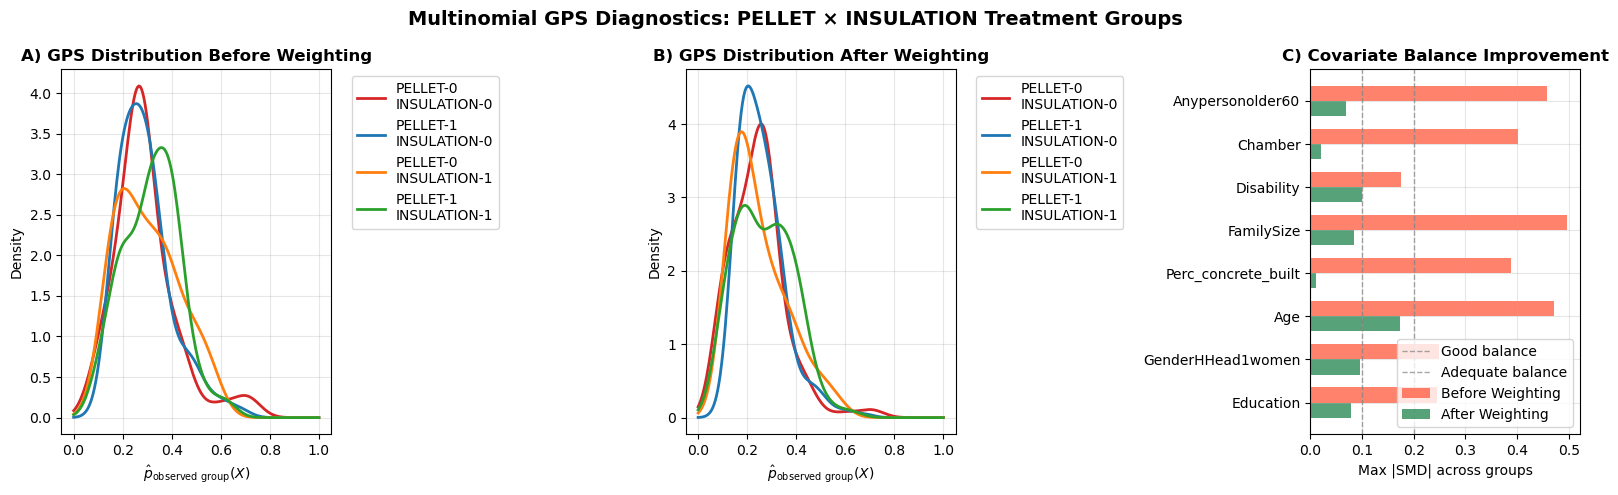


MULTINOMIAL GPS BALANCE ASSESSMENT
Maximum Absolute Standardized Mean Difference across treatment groups
Base covariates only:
----------------------------------------------------------------------
           variable  max_abs_smd_pre  max_abs_smd_post  improvement     Status
   Anypersonolder60            0.457             0.068        0.389     ✓ Good
            Chamber            0.402             0.020        0.382     ✓ Good
         Disability            0.175             0.100        0.075 ✓ Adequate
         FamilySize            0.497             0.085        0.412     ✓ Good
Perc_concrete_built            0.389             0.012        0.377     ✓ Good
                Age            0.471             0.173        0.298 ✓ Adequate
  GenderHHead1women            0.248             0.096        0.152     ✓ Good
          Education            0.244             0.080        0.165     ✓ Good
----------------------------------------------------------------------
Mean SMD improvemen

In [2]:
# Fixed Effects Regression Analysis - without matching

# df_pmi must contain: ON, T1, T2, ID, Hour, DayExp, and PM columns
required = ['ON','T1','T2','ID','Hour','DayExp']
for c in required:
    if c not in df_pmi.columns:
        raise ValueError(f"Missing column: {c}")
# Create new treatment variables with descriptive names
df_pmi['PELLET'] = df_pmi['T1']
df_pmi['INSULATION'] = df_pmi['T2']
# --- Add this cell right before model_cols / dropna ---
# Build LnPMo (log of outdoor PM). Also guard against non-positive values.
if 'LnPMo' not in df_pmi.columns:
    if 'Pmo_cal' in df_pmi.columns:
        df_pmi = df_pmi.loc[df_pmi['Pmo_cal'] > 0].copy()
        df_pmi['LnPMo'] = np.log(df_pmi['Pmo_cal'])
    elif 'PMo' in df_pmi.columns:
        df_pmi = df_pmi.loc[df_pmi['PMo'] > 0].copy()
        df_pmi['LnPMo'] = np.log(df_pmi['PMo'])
    else:
        raise ValueError("Provide outdoor PM as 'Pmo_cal' or 'PMo' to build LnPMo.")
# Build logs if needed
if 'LnPMi' not in df_pmi.columns:
    if 'Pmi_cal' in df_pmi.columns:
        df_pmi['LnPMi'] = np.log(df_pmi['Pmi_cal'])
    elif 'PMi' in df_pmi.columns:
        df_pmi['LnPMi'] = np.log(df_pmi['PMi'])
    else:
        raise ValueError("Provide indoor PM as 'Pmi_cal' or 'PMi' to build LnPMi.")
if 'LnTi' not in df_pmi.columns:
    if 'k_Ti' in df_pmi.columns:
        df_pmi['LnTi'] = np.log(df_pmi['k_Ti'])
    else:
        raise ValueError("Provide Ti.")
if 'LnTo' not in df_pmi.columns:
    if 'k_To' in df_pmi.columns:
        df_pmi['LnTo'] = np.log(df_pmi['k_To'])
    else:
        raise ValueError("Provide To.")
# Keep complete cases and cast FE as categorical

model_cols = ['LnPMi','ON','PELLET','INSULATION','LnPMo','LnTo','ID','Hour','DayExp','ON_Second']
df_t = df_pmi.dropna(subset=model_cols).copy()
for fe in ['ID','Hour','DayExp']:
    df_t[fe] = df_t[fe].astype('category')

# -----------------------------------------------------
# 1) Estimate FE model
# -----------------------------------------------------
# Specification matches your equation (no main effects PELLET/INSULATION; they're time-invariant)
formula = (
    "LnPMi ~ ON + ON:PELLET + ON:INSULATION + ON:PELLET:INSULATION + LnPMo + LnTo + ON_Second"
    "+ C(ID) + C(Hour) + C(DayExp)"
)
fe_fit = smf.ols(formula, data=df_t).fit(
    cov_type='cluster', cov_kwds={'groups': df_t['ID']}
)

# -----------------------------------------------------
# 2) Pretty summary (hide FE dummies)
# -----------------------------------------------------
print("=" * 86)
print("Fixed Effects Regression — ON effect by treatment group")
print("=" * 86)
print(f"Dependent variable : LnPMi")
print(f"Observations (N)   : {int(fe_fit.nobs):,}")
print(f"R-squared          : {fe_fit.rsquared:.3f}")
print(f"Adjusted R²        : {fe_fit.rsquared_adj:.3f}")
print(f"Covariance Type    : cluster (by ID)")
print(f"Fixed effects      : C(ID), C(Hour), C(DayExp)")
print("-" * 86)

# Show only substantive terms, not the FE dummies
candidate_terms = ['ON','ON:PELLET','ON:INSULATION','ON:PELLET:INSULATION','LnPMo','LnTo','ON_Second']
present_terms = [t for t in candidate_terms if t in fe_fit.params.index]

params_df = (
    pd.DataFrame({
        "Coef.":   fe_fit.params.loc[present_terms],
        "Std.Err": fe_fit.bse.loc[present_terms],
        "t":       fe_fit.tvalues.loc[present_terms],
        "P>|t|":   fe_fit.pvalues.loc[present_terms],
    })
    .round(4)
)
print("Main coefficients (FE dummies suppressed):")
print(params_df.to_string())
print("-" * 86)

# -----------------------------------------------------
# 3) Save coefficients for comparison
# -----------------------------------------------------
# Save main coefficients
coefs_no_matching = params_df.copy()
coefs_no_matching['Model'] = 'FE_No_Matching'
coefs_no_matching['N'] = int(fe_fit.nobs)
coefs_no_matching['R2'] = fe_fit.rsquared

# Save to file
coefs_no_matching.to_csv('coefficients_no_matching.csv', index=False)

print("\n✓ Coefficients saved for FE model without matching")
print(f"  - Coefficients: coefficients_no_matching.csv")

# -----------------------------------------------------
# Post-estimation: ON marginal effects by treatment group
#   - Uses the clustered VCV from fe_fit.cov_params()
#   - Exact SEs for linear combos (no independence assumption)
#   - Also reports % change = 100*(exp(beta) - 1)
# -----------------------------------------------------
import numpy as np
import pandas as pd
from scipy import stats as st

def lincom_sum(model, terms):
    """
    Compute linear combination b = sum(beta_j for j in terms),
    its standard error from the clustered covariance, and inference.
    """
    # Guard: ensure all requested terms are in the model
    missing = [t for t in terms if t not in model.params.index]
    if missing:
        raise KeyError(f"These terms are missing in the fitted model: {missing}")

    # Point estimate
    b = model.params.loc[terms].sum()

    # Variance of the sum: 1' * Cov[terms,terms] * 1
    V = model.cov_params().loc[terms, terms].values
    se = float(np.sqrt(V.sum()))  # since weights are all 1

    # Inference with model degrees of freedom
    df = int(model.df_resid)
    tval = b / se if se > 0 else np.nan
    pval = 2 * (1 - st.t.cdf(abs(tval), df=df)) if se > 0 else np.nan

    # 95% CI
    tcrit = st.t.ppf(0.975, df=df)
    ci_lo, ci_hi = b - tcrit * se, b + tcrit * se

    # Percent change for log-linear outcome
    pct = 100 * (np.exp(b) - 1)
    pct_lo = 100 * (np.exp(ci_lo) - 1)
    pct_hi = 100 * (np.exp(ci_hi) - 1)

    return {
        "Effect (beta)": b,
        "Std. Error": se,
        "t": tval,
        "p>|t|": pval,
        "CI95 Low": ci_lo,
        "CI95 High": ci_hi,
        "% Change": pct,
        "%CI95 Low": pct_lo,
        "%CI95 High": pct_hi,
    }

# Define the four treatment-group ON effects as linear sums
groups = {
    "Firewood – No Insulation": ["ON"],
    "Pellet only": ["ON", "ON:PELLET"],
    "Insulation only": ["ON", "ON:INSULATION"],
    "Pellet + Insulation": ["ON", "ON:PELLET", "ON:INSULATION", "ON:PELLET:INSULATION"],
}

# Compute and present results
rows = []
for label, terms in groups.items():
    res = lincom_sum(fe_fit, terms)
    res["Group"] = label
    res["Expression"] = " + ".join(terms)
    rows.append(res)

effects_df = (
    pd.DataFrame(rows)
    .set_index("Group")
    .loc[list(groups.keys()), :]  # keep defined order
    .round({
        "Effect (beta)": 4, "Std. Error": 4, "t": 2, "p>|t|": 4,
        "CI95 Low": 4, "CI95 High": 4, "% Change": 1, "%CI95 Low": 1, "%CI95 High": 1
    })
)

print("\n" + "="*86)
print("Marginal ON Effects by Treatment Group (cluster-robust, from FE model)")
print("="*86)
display_cols = [
    "Expression", "Effect (beta)", "Std. Error", "t", "p>|t|",
    "CI95 Low", "CI95 High", "% Change", "%CI95 Low", "%CI95 High"
]
print(effects_df[display_cols].to_string())

# Save to CSV for your report
effects_df.to_csv("marginal_ON_effects_no_matching.csv")
print("\n✓ Saved: marginal_ON_effects_no_matching.csv")


# Fixed Effects Regression Analysis - with matching

# ============================================
# Now with matching - ENHANCED WITH INTERACTIONS
# MULTINOMIAL GPS WEIGHTS FOR (PELLET,INSULATION) JOINTLY
# ============================================

# 1) One row per ID with observed (PELLET,INSULATION), then build Group
id_t = (
    df_pmi[["ID","PELLET","INSULATION"]]
    .drop_duplicates(subset=["ID"])
    .copy()
)

id_t["Group"] = (
    id_t["PELLET"].astype(int).astype(str) + id_t["INSULATION"].astype(int).astype(str)
)
# Map to 4 labels 0..3
group_map = {"00":0, "10":1, "01":2, "11":3}
id_t["Group"] = id_t["Group"].map(group_map).astype(int)

# 2) Merge covariates for PS model (df_imputed from your imputation step)
# ENHANCED: Base covariates + interaction terms
base_covs = [
    "Anypersonolder60", "Chamber", "Disability", "FamilySize", 
    "Perc_concrete_built", "Age", "GenderHHead1women", "Education"
]

cov_need = ["ID"] + base_covs  # Only need base covariates for merging
missing_cols = [c for c in cov_need if c not in df_imputed.columns]
if missing_cols:
    raise ValueError(f"Missing columns in df_imputed: {missing_cols}")

# CREATE gps_df FIRST before adding interactions
gps_df = id_t.merge(df_imputed[cov_need], on="ID", how="left").copy()

# NOW add interaction terms to dataframe
print("Creating interaction terms...")
for var1, var2 in interaction_pairs:
    interaction_name = f"{var1}_{var2}_interaction"
    gps_df[interaction_name] = gps_df[var1] * gps_df[var2]
    print(f"  Created: {interaction_name}")

# Enhanced covariate set
ps_covs = base_covs + [f"{var1}_{var2}_interaction" for var1, var2 in interaction_pairs]
print(f"Using {len(ps_covs)} covariates total: {len(base_covs)} base + {len(interaction_pairs)} interactions")

# Minimal safety fill (should mostly be filled already)
for c in base_covs:  # Only fill base covariates
    if gps_df[c].isna().any():
        if gps_df[c].dtype.kind in "biufc":
            gps_df[c] = gps_df[c].fillna(gps_df[c].median())
        else:
            mode_val = gps_df[c].mode().iloc[0] if not gps_df[c].mode().empty else 0
            gps_df[c] = gps_df[c].fillna(mode_val)

# 3) Enhanced Multinomial logit: P(Group=k | X) with interactions
print(f"Fitting multinomial logit with {len(ps_covs)} covariates...")
X = gps_df[ps_covs].copy()
y = gps_df["Group"].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

mlogit = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000)
mlogit.fit(X_scaled, y)
probs = mlogit.predict_proba(X_scaled)  # shape (N,4)

# 4) Stabilized weights: sw = P(Group=k)/p_hat_k(X)
# Empirical marginals:
pi = gps_df["Group"].value_counts(normalize=True).sort_index().reindex([0,1,2,3]).values
# Pick each unit's prob of its observed group
p_hat = probs[np.arange(len(gps_df)), y.values]
sw = pi[y.values] / p_hat

gps_df["weight_gps"] = sw

# (Optional but recommended) Trimming to control extreme weights
lo, hi = np.percentile(gps_df["weight_gps"], [1, 99])
gps_df["weight_gps"] = gps_df["weight_gps"].clip(lower=lo, upper=hi)

print("Multinomial GPS weights summary (with interactions):")
print(gps_df["weight_gps"].describe())

# 5) Merge weights back to the panel and run WEIGHTED FE (WLS)
df_pmi_w = df_pmi.merge(gps_df[["ID","weight_gps"]], on="ID", how="inner").copy()

# Ensure temperature variables are properly created
df_pmi_w['k_Ti'] = (df_pmi_w['Ti'] + 273)
df_pmi_w['k_To'] = (df_pmi_w['To'] + 273)
df_pmi_w['LnTi'] = np.log(df_pmi_w['k_Ti'])
df_pmi_w['LnTo'] = np.log(df_pmi_w['k_To'])

formula_w = (
    "LnPMi ~ ON + ON:PELLET + ON:INSULATION + ON:PELLET:INSULATION + LnPMo + LnTo + ON_Second"
    "+ C(ID) + C(Hour) + C(DayExp)"
)

if two_way_cluster:
    groups_2d = np.c_[df_pmi_w['ID'].cat.codes.values, df_pmi_w['DayExp'].values]
    fe_log_w = smf.wls(formula_w, data=df_pmi_w, weights=df_pmi_w["weight_gps"]).fit(
        cov_type="cluster",
        cov_kwds={"groups": groups_2d}
    )
else:
    fe_log_w = smf.wls(formula_w, data=df_pmi_w, weights=df_pmi_w["weight_gps"]).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_pmi_w["ID"]}
    )

# -----------------------
# Custom summary without fixed effects coefficients
# -----------------------
print("\n" + "="*78)
print("WEIGHTED FE MODEL (WLS, multinomial GPS with interactions)")
print("Fixed Effects Coefficients Suppressed")
print("="*78)
print(f"Dep. Variable: {'LnPMi':<20} R-squared: {fe_log_w.rsquared:.3f}")
print(f"Model: {'WLS':<22} Adj. R-squared: {fe_log_w.rsquared_adj:.3f}")
print(f"Method: {'Least Squares':<18} F-statistic: {fe_log_w.fvalue:.2f}")
print(f"Date: {pd.Timestamp.now().strftime('%a, %d %b %Y'):<20} Prob (F-statistic): {fe_log_w.f_pvalue:.2e}")
print(f"Time: {pd.Timestamp.now().strftime('%H:%M:%S'):<20} Log-Likelihood: {fe_log_w.llf:.1f}")
print(f"No. Observations: {fe_log_w.nobs:<8} AIC: {fe_log_w.aic:.1f}")
print(f"Df Residuals: {fe_log_w.df_resid:<14} BIC: {fe_log_w.bic:.1f}")
print(f"Df Model: {fe_log_w.df_model:<16} Covariance Type: cluster")
print("="*78)

# Create a summary table without the fixed effects
params_summary = fe_log_w.summary().tables[1]
params_df = pd.read_html(params_summary.as_html(), header=0, index_col=0)[0]

# Filter out fixed effects coefficients
keep_terms = ['Intercept', 'ON', 'ON:PELLET', 'ON:INSULATION', 'ON:PELLET:INSULATION', 'LnPMo','LnTo','ON_Second']

filtered_params = params_df[params_df.index.isin(keep_terms)]

print(filtered_params.to_string(float_format=lambda x: f'{x:.4f}'))
print("="*78)

# Get diagnostics from the full summary
full_summary = fe_log_w.summary()
diagnostics_table = full_summary.tables[2]

# Print diagnostics
print(diagnostics_table.as_text())
print("="*78)
print("Notes:")
print("[1] Standard Errors are robust to cluster correlation (cluster)")
print("[2] Fixed effects coefficients for C(ID), C(Hour), C(DayExp) are suppressed")
if fe_log_w.condition_number > 1e3:
    print(f"[3] The condition number is large, {fe_log_w.condition_number:.2e}. This might indicate")
    print("    that there are strong multicollinearity or other numerical problems.")

# 6) Save coefficients for comparison
# ---------------------------------------------------
# Save main coefficients
coefs_matching = filtered_params.copy()
coefs_matching['Model'] = 'FE_With_Matching'
coefs_matching['N'] = int(fe_log_w.nobs)
coefs_matching['R2'] = fe_log_w.rsquared

# Save to file
coefs_matching.to_csv('coefficients_with_matching.csv', index=False)

print("\n✓ Coefficients saved for FE model with matching")
print(f"  - Coefficients: coefficients_with_matching.csv")


# -----------------------------------------------------
# Post-estimation: ON marginal effects by treatment group (WITH MATCHING)
# -----------------------------------------------------
import numpy as np
import pandas as pd
from scipy import stats as st

def lincom_sum(model, terms):
    """
    Compute linear combination b = sum(beta_j for j in terms),
    its standard error from the clustered covariance, and inference.
    """
    # Guard: ensure all requested terms are in the model
    missing = [t for t in terms if t not in model.params.index]
    if missing:
        raise KeyError(f"These terms are missing in the fitted model: {missing}")

    # Point estimate
    b = model.params.loc[terms].sum()

    # Variance of the sum: 1' * Cov[terms,terms] * 1
    V = model.cov_params().loc[terms, terms].values
    se = float(np.sqrt(V.sum()))  # since weights are all 1

    # Inference with model degrees of freedom
    df = int(model.df_resid)
    tval = b / se if se > 0 else np.nan
    pval = 2 * (1 - st.t.cdf(abs(tval), df=df)) if se > 0 else np.nan

    # 95% CI
    tcrit = st.t.ppf(0.975, df=df)
    ci_lo, ci_hi = b - tcrit * se, b + tcrit * se

    # Percent change for log-linear outcome
    pct = 100 * (np.exp(b) - 1)
    pct_lo = 100 * (np.exp(ci_lo) - 1)
    pct_hi = 100 * (np.exp(ci_hi) - 1)

    return {
        "Effect (beta)": b,
        "Std. Error": se,
        "t": tval,
        "p>|t|": pval,
        "CI95 Low": ci_lo,
        "CI95 High": ci_hi,
        "% Change": pct,
        "%CI95 Low": pct_lo,
        "%CI95 High": pct_hi,
    }

# Define the four treatment-group ON effects as linear sums
groups = {
    "Firewood – No Insulation": ["ON"],
    "Pellet only": ["ON", "ON:PELLET"],
    "Insulation only": ["ON", "ON:INSULATION"],
    "Pellet + Insulation": ["ON", "ON:PELLET", "ON:INSULATION", "ON:PELLET:INSULATION"],
}

# Compute and present results
rows = []
for label, terms in groups.items():
    res = lincom_sum(fe_log_w, terms)  # Using fe_log_w (matching model)
    res["Group"] = label
    res["Expression"] = " + ".join(terms)
    rows.append(res)

effects_df_matching = (
    pd.DataFrame(rows)
    .set_index("Group")
    .loc[list(groups.keys()), :]  # keep defined order
    .round({
        "Effect (beta)": 4, "Std. Error": 4, "t": 2, "p>|t|": 4,
        "CI95 Low": 4, "CI95 High": 4, "% Change": 1, "%CI95 Low": 1, "%CI95 High": 1
    })
)

print("\n" + "="*86)
print("Marginal ON Effects by Treatment Group (cluster-robust, from FE model WITH MATCHING)")
print("="*86)
display_cols = [
    "Expression", "Effect (beta)", "Std. Error", "t", "p>|t|",
    "CI95 Low", "CI95 High", "% Change", "%CI95 Low", "%CI95 High"
]
print(effects_df_matching[display_cols].to_string())

# Save the effects
effects_df_matching['Model'] = 'FE_With_Matching'
effects_df_matching.to_csv('treatment_effects_with_matching.csv', index=True)

print("\n✓ Treatment effects saved for FE model with matching")
print(f"  - File: treatment_effects_with_matching.csv")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ---------------------------------------------------
# 1) Helper functions
# ---------------------------------------------------
def _weighted_kde_eval(x, grid, w=None):
    """Weighted kernel density estimation"""
    x = np.asarray(x, float)
    if w is None:
        w = np.ones_like(x)
    if len(x) < 3 or np.isclose(np.std(x), 0):
        return np.zeros_like(grid, dtype=float)
    kde = gaussian_kde(x, weights=w)
    return kde(grid)

def smd_multi_group(df, group_col, covars, weight_col=None):
    """Compute max |SMD| across all group pairs for each covariate."""
    out = []
    groups = sorted(df[group_col].unique())
    w_all = df[weight_col].values if weight_col else np.ones(len(df))
    for v in covars:
        smds = []
        for g in groups:
            mask_g = (df[group_col] == g)
            wg = w_all[mask_g]
            xg = df.loc[mask_g, v].astype(float)
            wg = wg / wg.sum() if wg.sum() > 0 else np.ones_like(wg)/len(wg)
            mean_g = np.sum(wg * xg)
            var_g = np.sum(wg * (xg - mean_g)**2)
            smds.append((mean_g, var_g))
        pooled_sd = np.sqrt(np.mean([v[1] for v in smds]))
        pooled_sd = pooled_sd if pooled_sd > 0 else 1
        means = [m[0] for m in smds]
        diffs = [abs(mi - mj)/pooled_sd for i, mi in enumerate(means)
                 for j, mj in enumerate(means) if j > i]
        out.append(dict(variable=v, max_abs_smd=np.max(diffs)))
    return pd.DataFrame(out)

# ---------------------------------------------------
# 2) Data preparation for diagnostics
# ---------------------------------------------------
y_plot = gps_df["Group"].to_numpy()
w_plot = gps_df["weight_gps"].to_numpy()
assert probs.shape[0] == len(y_plot), "Mismatch between probs and Group labels."

grid = np.linspace(0, 1, 200)
groups = np.sort(np.unique(y_plot))

# Create descriptive group labels for 4 groups
group_labels = {
    0: "PELLET-0\nINSULATION-0",
    1: "PELLET-1\nINSULATION-0", 
    2: "PELLET-0\nINSULATION-1",
    3: "PELLET-1\nINSULATION-1"
}

# Define custom colors for treatment groups
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c']  # Red, Blue, Orange, Green
# ---------------------------------------------------
# 3) Covariate balance assessment
# ---------------------------------------------------
# Check balance on BASE covariates only (not interactions or squares)
covars_for_balance = base_covs.copy()

bal_df = gps_df.copy()
pre  = smd_multi_group(bal_df, "Group", covars_for_balance, weight_col=None)
post = smd_multi_group(bal_df, "Group", covars_for_balance, weight_col="weight_gps")

smd_comp = pre.merge(post, on="variable", suffixes=("_pre","_post"))
smd_comp["improvement"] = smd_comp["max_abs_smd_pre"] - smd_comp["max_abs_smd_post"]

# ---------------------------------------------------
# 4) Comprehensive diagnostics figure
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
grid = np.linspace(0, 1, 200)

# --- Panel A: Density before weighting ---
ax = axes[0]
#colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))
for i, g in enumerate(groups):
    mask = (y_plot == g)
    xg = probs[mask, g]
    fk = _weighted_kde_eval(xg, grid)
    ax.plot(grid, fk, label=group_labels[g], linewidth=2, color=colors[i])
ax.set_title("A) GPS Distribution Before Weighting", fontweight='bold')
ax.set_xlabel(r"$\hat{p}_{\mathrm{observed\ group}}(X)$")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# --- Panel B: Density after weighting ---
ax = axes[1]
for i, g in enumerate(groups):
    mask = (y_plot == g)
    xg = probs[mask, g]
    wg = w_plot[mask]
    fk = _weighted_kde_eval(xg, grid, wg)
    ax.plot(grid, fk, label=group_labels[g], linewidth=2, color=colors[i])
ax.set_title("B) GPS Distribution After Weighting", fontweight='bold')
ax.set_xlabel(r"$\hat{p}_{\mathrm{observed\ group}}(X)$")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# --- Panel C: Covariate balance improvement ---
ax = axes[2]
idx = np.arange(len(smd_comp))
barw = 0.35
ax.barh(idx - barw/2, smd_comp["max_abs_smd_pre"], height=barw, color="tomato", 
        label="Before Weighting", alpha=0.8)
ax.barh(idx + barw/2, smd_comp["max_abs_smd_post"], height=barw, color="seagreen", 
        label="After Weighting", alpha=0.8)
ax.axvline(0.1, color="gray", linestyle="--", linewidth=1, alpha=0.7, label="Good balance")
ax.axvline(0.2, color="gray", linestyle="--", linewidth=1, alpha=0.7, label="Adequate balance")
ax.set_yticks(idx)
ax.set_yticklabels(smd_comp["variable"])
ax.invert_yaxis()
ax.set_xlabel("Max |SMD| across groups")
ax.set_title("C) Covariate Balance Improvement", fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

fig.suptitle("Multinomial GPS Diagnostics: PELLET × INSULATION Treatment Groups", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 5) Balance results table
# ---------------------------------------------------
print("\n" + "="*70)
print("MULTINOMIAL GPS BALANCE ASSESSMENT")
print("="*70)
print("Maximum Absolute Standardized Mean Difference across treatment groups")
print("Base covariates only:")
print("-" * 70)

# Format the balance table with status indicators
balance_table = smd_comp.copy()
balance_table = balance_table.round(3)
balance_table["Status"] = balance_table["max_abs_smd_post"].apply(
    lambda x: "✓ Good" if x < 0.1 else "✓ Adequate" if x < 0.2 else "⚠ Needs attention"
)

print(balance_table[["variable", "max_abs_smd_pre", "max_abs_smd_post", "improvement", "Status"]].to_string(index=False))

print("-" * 70)
print(f"Mean SMD improvement: {smd_comp['improvement'].mean():.3f}")
print(f"Covariates with good balance (SMD < 0.1): {(smd_comp['max_abs_smd_post'] < 0.1).sum()}/{len(smd_comp)}")
print(f"Covariates with adequate balance (SMD < 0.2): {(smd_comp['max_abs_smd_post'] < 0.2).sum()}/{len(smd_comp)}")

# ---------------------------------------------------
# 6) Treatment group summary
# ---------------------------------------------------
print("\n" + "="*70)
print("TREATMENT GROUP DISTRIBUTION")
print("="*70)

group_counts = gps_df["Group"].value_counts().sort_index()
for group_id, count in group_counts.items():
    print(f"{group_labels[group_id]}: {count} households")

print("-" * 70)
print(f"Total households: {len(gps_df)}")
print(f"Effective sample size: {(gps_df['weight_gps'].sum()**2) / (gps_df['weight_gps']**2).sum():.1f}")
print("="*70)


## Figure 2 (new)

Data aggregation complete!
PM2.5 data shape: (96, 7)
Temperature data shape: (96, 7)


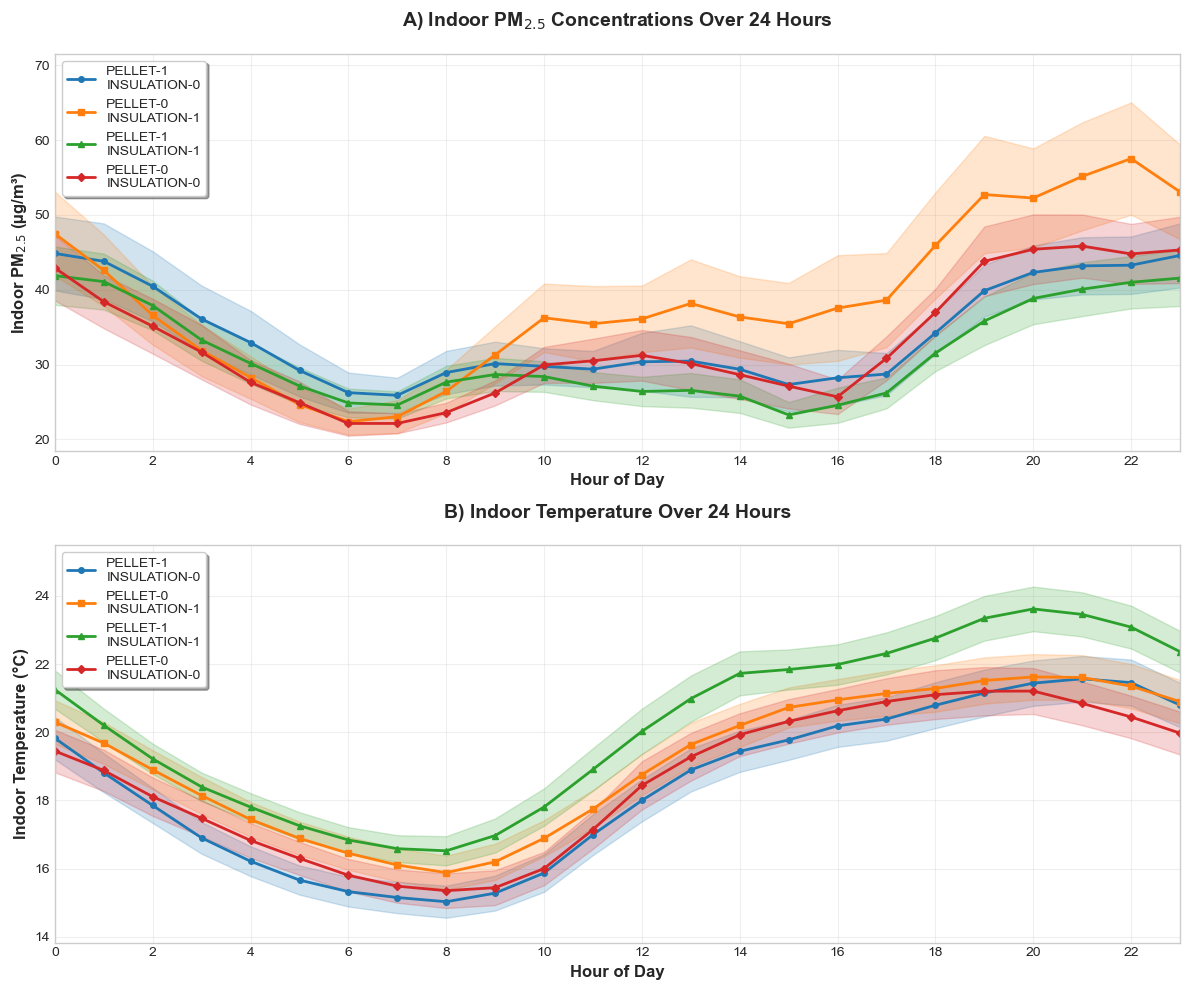

Figure 2 replacement created successfully!


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for better readability
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Create treatment groups in your panel data
df_pmi['treatment_group'] = 'Unknown'
df_pmi.loc[(df_pmi['PELLET'] == 0) & (df_pmi['INSULATION'] == 0), 'treatment_group'] = 'PELLET-0\nINSULATION-0'
df_pmi.loc[(df_pmi['PELLET'] == 1) & (df_pmi['INSULATION'] == 0), 'treatment_group'] = 'PELLET-1\nINSULATION-0'
df_pmi.loc[(df_pmi['PELLET'] == 0) & (df_pmi['INSULATION'] == 1), 'treatment_group'] = 'PELLET-0\nINSULATION-1'
df_pmi.loc[(df_pmi['PELLET'] == 1) & (df_pmi['INSULATION'] == 1), 'treatment_group'] = 'PELLET-1\nINSULATION-1'


# Aggregate by hour and treatment group for PM2.5
pm_hourly = df_pmi.groupby(['Hour', 'treatment_group'])['Pmi_cal'].agg([
    'mean', 
    'std', 
    'count'
]).reset_index()

# Calculate confidence intervals (95%)
pm_hourly['ci_lower'] = pm_hourly['mean'] - 1.96 * pm_hourly['std'] / np.sqrt(pm_hourly['count'])
pm_hourly['ci_upper'] = pm_hourly['mean'] + 1.96 * pm_hourly['std'] / np.sqrt(pm_hourly['count'])

# Aggregate by hour and treatment group for temperature
temp_hourly = df_pmi.groupby(['Hour', 'treatment_group'])['Ti'].agg([
    'mean', 
    'std', 
    'count'
]).reset_index()

# Calculate confidence intervals (95%)
temp_hourly['ci_lower'] = temp_hourly['mean'] - 1.96 * temp_hourly['std'] / np.sqrt(temp_hourly['count'])
temp_hourly['ci_upper'] = temp_hourly['mean'] + 1.96 * temp_hourly['std'] / np.sqrt(temp_hourly['count'])

print("Data aggregation complete!")
print(f"PM2.5 data shape: {pm_hourly.shape}")
print(f"Temperature data shape: {temp_hourly.shape}")

# Define colors with good B/W contrast
groups = {
    'PELLET-1\nINSULATION-0': {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o'},      # Blue
    'PELLET-0\nINSULATION-1': {'color': '#ff7f0e', 'linestyle': '-', 'marker': 's'},  # Orange 
    'PELLET-1\nINSULATION-1': {'color': '#2ca02c', 'linestyle': '-', 'marker': '^'}, # Green
    'PELLET-0\nINSULATION-0': {'color': '#d62728', 'linestyle': '-', 'marker': 'D'}     # Red
}





# Create the actual plot with your real data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot actual PM2.5 data
for group_name, style in groups.items():
    group_data = pm_hourly[pm_hourly['treatment_group'] == group_name]
    if len(group_data) > 0:
        ax1.plot(group_data['Hour'], group_data['mean'], 
                 label=group_name, 
                 color=style['color'],
                 linestyle=style['linestyle'],
                 marker=style['marker'],
                 markersize=4,
                 linewidth=2)
        
        # Add confidence intervals
        ax1.fill_between(group_data['Hour'], 
                        group_data['ci_lower'], 
                        group_data['ci_upper'],
                        alpha=0.2, color=style['color'])

# PM2.5 plot formatting
ax1.set_ylabel('Indoor PM$_{2.5}$ (µg/m³)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_title('A) Indoor PM$_{2.5}$ Concentrations Over 24 Hours', 
              fontsize=14, fontweight='bold', pad=20)

# Set appropriate y-axis range for PM2.5 (don't start at zero)
pm_min = max(0, pm_hourly['ci_lower'].min() * 0.9)  # Don't go below zero
pm_max = pm_hourly['ci_upper'].max() * 1.1
ax1.set_ylim(pm_min, pm_max)
ax1.set_xlim(0, 23)
ax1.set_xticks(np.arange(0, 24, 2))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

# Add WHO guideline reference line
ax1.axhline(y=15, color='red', linestyle='--', alpha=0.7, linewidth=1,
           label='WHO 24-h guideline')

# Plot actual temperature data
for group_name, style in groups.items():
    group_data = temp_hourly[temp_hourly['treatment_group'] == group_name]
    if len(group_data) > 0:
        ax2.plot(group_data['Hour'], group_data['mean'], 
                 label=group_name, 
                 color=style['color'],
                 linestyle=style['linestyle'],
                 marker=style['marker'],
                 markersize=4,
                 linewidth=2)
        
        # Add confidence intervals
        ax2.fill_between(group_data['Hour'], 
                        group_data['ci_lower'], 
                        group_data['ci_upper'],
                        alpha=0.2, color=style['color'])

# Temperature plot formatting
ax2.set_ylabel('Indoor Temperature (°C)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax2.set_title('B) Indoor Temperature Over 24 Hours', 
              fontsize=14, fontweight='bold', pad=20)

# Set appropriate y-axis range for temperature (don't start at zero)
temp_min = temp_hourly['ci_lower'].min() * 0.95
temp_max = temp_hourly['ci_upper'].max() * 1.05
ax2.set_ylim(temp_min, temp_max)
ax2.set_xlim(0, 23)
ax2.set_xticks(np.arange(0, 24, 2))
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print("Figure 2 replacement created successfully!")

## Balance Assessment 

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

# ============================================
# 1. Prepare the data with treatment groups
# ============================================

# Create treatment groups in your covariates data
df_cov = df_imputed.copy()
df_cov['treatment_group'] = 'Unknown'

# Merge with treatment information from panel data
treatment_info = df_pmi[['ID', 'PELLET', 'INSULATION']].drop_duplicates()
df_cov = df_cov.merge(treatment_info, on='ID', how='left')

# Create the 4 treatment groups
df_cov.loc[(df_cov['PELLET'] == 0) & (df_cov['INSULATION'] == 0), 'treatment_group'] = 'PELLET-0\INSULATION-0'
df_cov.loc[(df_cov['PELLET'] == 1) & (df_cov['INSULATION'] == 0), 'treatment_group'] = 'PELLET-1\INSULATION-0'
df_cov.loc[(df_cov['PELLET'] == 0) & (df_cov['INSULATION'] == 1), 'treatment_group'] = 'PELLET-0\INSULATION-1'
df_cov.loc[(df_cov['PELLET'] == 1) & (df_cov['INSULATION'] == 1), 'treatment_group'] = 'PELLET-1\INSULATION-1'




# Remove any rows with unknown treatment group
df_cov = df_cov[df_cov['treatment_group'] != 'Unknown']

# Define the covariates to test
covariates = [
    "FamilySize", 
    "Education", 
    "GenderHHead1women", 
    "Age", 
    "Disability", 
    "Anypersonolder60", 
    "Chamber", 
    "Perc_concrete_built"
]

# Create descriptive names for display
covariate_names = {
    "FamilySize": "Household size",
    "Education": "Years of schooling", 
    "GenderHHead1women": "Female head",
    "Age": "Age of head",
    "Disability": "Any disability",
    "Anypersonolder60": "Any >60 years", 
    "Chamber": "Double chamber",
    "Perc_concrete_built": "Concrete share"
}

# ============================================
# 2. Create main table with groups in rows
# ============================================

# Initialize results for group statistics
group_stats = []

treatment_groups = ['PELLET-0\INSULATION-0', 'PELLET-1\INSULATION-0', 'PELLET-0\INSULATION-1', 'PELLET-1\INSULATION-1']




for group in treatment_groups:
    group_data = df_cov[df_cov['treatment_group'] == group]
    group_result = {'Group': group, 'N': len(group_data)}
    
    for covariate in covariates:
        mean_val = group_data[covariate].mean()
        std_val = group_data[covariate].std()
        group_result[covariate_names[covariate]] = f"{mean_val:.2f} ({std_val:.2f})"
    
    group_stats.append(group_result)

# Convert to DataFrame
main_table = pd.DataFrame(group_stats)

# Reorder columns
column_order = ['Group', 'N'] + [covariate_names[c] for c in covariates]
main_table = main_table[column_order]

# ============================================
# 3. Create pairwise t-test table
# ============================================

# Function to format p-value with stars
def format_pvalue(p_val):
    if pd.isna(p_val):
        return "NA"
    elif p_val < 0.001:
        return f"{p_val:.4f}***"
    elif p_val < 0.01:
        return f"{p_val:.4f}**"
    elif p_val < 0.05:
        return f"{p_val:.4f}*"
    else:
        return f"{p_val:.4f}"

# All pairwise combinations
all_pairs = list(combinations(treatment_groups, 2))

# Initialize pairwise results
pairwise_results = []

for pair in all_pairs:
    group1, group2 = pair
    comparison_row = {'Comparison': f"{group1} vs {group2}"}
    
    for covariate in covariates:
        data1 = df_cov[df_cov['treatment_group'] == group1][covariate].dropna()
        data2 = df_cov[df_cov['treatment_group'] == group2][covariate].dropna()
        
        if len(data1) > 1 and len(data2) > 1:
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            comparison_row[covariate_names[covariate]] = format_pvalue(p_value)
        else:
            comparison_row[covariate_names[covariate]] = "NA"
    
    pairwise_results.append(comparison_row)

pairwise_table = pd.DataFrame(pairwise_results)

# ============================================
# 4. Display the tables
# ============================================

print("\n" + "="*90)
print("TABLE 1: COVARIATE BALANCE BY TREATMENT GROUP")
print("="*90)
print("Values show Mean (Standard Deviation)")
print("="*90)

# Display main table
print(main_table.to_string(index=False))

print("\n" + "="*90)
print("TABLE 2: PAIRWISE T-TEST P-VALUES")
print("="*90)
print("Welch's t-test (unequal variances assumed)")
print("="*90)

# Display pairwise table
print(pairwise_table.to_string(index=False))

print("\n" + "="*90)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("="*90)

# ============================================
# 5. Summary statistics and interpretation
# ============================================

print("\n" + "="*60)
print("BALANCE ASSESSMENT SUMMARY")
print("="*60)

# Count significant differences for each variable
sig_summary = []
for covariate in covariates:
    var_name = covariate_names[covariate]
    sig_count = 0
    total_comparisons = len(all_pairs)
    
    for result in pairwise_results:
        p_val_str = result[var_name]
        if '*' in p_val_str and p_val_str != "NA":
            sig_count += 1
    
    sig_summary.append({
        'Variable': var_name,
        'Significant Differences': f"{sig_count}/{total_comparisons}",
        'Balance Status': 'Balanced' if sig_count == 0 else 'Imbalanced'
    })

sig_df = pd.DataFrame(sig_summary)
print("\nSignificant Differences by Variable:")
print(sig_df.to_string(index=False))

# Overall assessment
balanced_vars = len([x for x in sig_summary if x['Balance Status'] == 'Balanced'])
print(f"\nOverall: {balanced_vars}/{len(covariates)} variables show no significant differences")

# ============================================
# 6. Save to Excel with formatted sheets
# ============================================

with pd.ExcelWriter('transposed_balance_table.xlsx') as writer:
    # Main table
    main_table.to_excel(writer, sheet_name='Group_Means_SD', index=False)
    
    # Pairwise tests
    pairwise_table.to_excel(writer, sheet_name='Pairwise_Tests', index=False)
    
    # Summary
    sig_df.to_excel(writer, sheet_name='Balance_Summary', index=False)
    
    # Raw data for verification
    raw_data = df_cov[['treatment_group'] + covariates]
    raw_data.to_excel(writer, sheet_name='Raw_Data', index=False)

print("\n✓ Tables saved to: transposed_balance_table.xlsx")

# ============================================
# 7. Compact version for paper appendix
# ============================================

print("\n" + "="*80)
print("COMPACT VERSION FOR PAPER")
print("="*80)

# Create a compact version that combines means and key p-values
compact_results = []

# Add group means first
for group in treatment_groups:
    group_data = df_cov[df_cov['treatment_group'] == group]
    row_data = {'Group/Comparison': group}
    
    for covariate in covariates:
        mean_val = group_data[covariate].mean()
        std_val = group_data[covariate].std()
        row_data[covariate_names[covariate]] = f"{mean_val:.2f} ({std_val:.2f})"
    
    compact_results.append(row_data)

# Add key pairwise comparisons
key_comparisons = [
    ('PELLET-0\INSULATION-0', 'PELLET-1\INSULATION-0'),
    ('PELLET-0\INSULATION-0', 'PELLET-1\INSULATION-1'),
    ('PELLET-1\INSULATION-0', 'PELLET-1\INSULATION-1')
]

for group1, group2 in key_comparisons:
    # Use the full group names for clarity
    comp_name = f"{group1} vs {group2}"
    row_data = {'Group/Comparison': comp_name}
    
    for covariate in covariates:
        data1 = df_cov[df_cov['treatment_group'] == group1][covariate].dropna()
        data2 = df_cov[df_cov['treatment_group'] == group2][covariate].dropna()
        
        if len(data1) > 1 and len(data2) > 1:
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            row_data[covariate_names[covariate]] = format_pvalue(p_value)
        else:
            row_data[covariate_names[covariate]] = "NA"
    
    compact_results.append(row_data)

compact_table = pd.DataFrame(compact_results)
print("\nCompact Table (Means + Key Comparisons):")
print(compact_table.to_string(index=False))


TABLE 1: COVARIATE BALANCE BY TREATMENT GROUP
Values show Mean (Standard Deviation)
                Group  N Household size Years of schooling Female head   Age of head Any disability Any >60 years Double chamber Concrete share
PELLET-0\INSULATION-0 94    3.63 (1.57)       11.35 (4.04) 0.68 (0.47) 55.63 (16.27)    0.40 (0.49)   0.54 (0.50)    0.66 (0.48)    0.32 (0.31)
PELLET-1\INSULATION-0 94    3.29 (1.21)       11.65 (3.96) 0.59 (0.50) 55.79 (15.32)    0.44 (0.50)   0.62 (0.49)    0.67 (0.47)    0.39 (0.36)
PELLET-0\INSULATION-1 94    3.16 (1.31)       10.89 (3.55) 0.70 (0.46) 54.32 (15.43)    0.35 (0.48)   0.46 (0.50)    0.55 (0.50)    0.26 (0.29)
PELLET-1\INSULATION-1 97    2.97 (1.20)       11.80 (3.40) 0.67 (0.47) 61.33 (12.62)    0.36 (0.48)   0.68 (0.47)    0.74 (0.44)    0.38 (0.34)

TABLE 2: PAIRWISE T-TEST P-VALUES
Welch's t-test (unequal variances assumed)
                                    Comparison Household size Years of schooling Female head Age of head Any disabili

## Balance Assessment on households wiht Self-funded Insulation
What we learn: Self-funded households are systematically different - younger, fewer elderly, less concrete construction, and more female-headed than MINVU-subsidized households.

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# ============================================
# 1. Load and merge MINVU data
# ============================================

# Load MINVU data
minvu_data = pd.read_excel("Panel_03112025.xlsx", sheet_name="MINVU")

#print("MINVU data structure:")
#print(minvu_data.head())
#print(f"\nMINVU data shape: {minvu_data.shape}")

# Merge with df_imputed to get covariates
df_minvu_analysis = df_imputed.merge(minvu_data[['ID', 'INSULATION', 'MINVU']], on='ID', how='inner')

#print(f"\nAfter merging - data shape: {df_minvu_analysis.shape}")

# ============================================
# 2. Filter for households with insulation (INSULATION = 1)
# ============================================

df_insulated = df_minvu_analysis[df_minvu_analysis['INSULATION'] == 1].copy()

print(f"\nHouseholds with insulation: {len(df_insulated)}")
print("Breakdown by MINVU subsidy:")
print(df_insulated['MINVU'].value_counts())

# Create the two comparison groups
self_funded = df_insulated[df_insulated['MINVU'] == 0]  # Self-funded insulation
minvu_subsidized = df_insulated[df_insulated['MINVU'] == 1]  # MINVU-subsidized insulation

print(f"\nSelf-funded insulation: {len(self_funded)} households")
print(f"MINVU-subsidized insulation: {len(minvu_subsidized)} households")

# ============================================
# 3. Define covariates for comparison
# ============================================

covariates = [
    "FamilySize", 
    "Education", 
    "GenderHHead1women", 
    "Age", 
    "Disability", 
    "Anypersonolder60", 
    "Chamber", 
    "Perc_concrete_built"
]

covariate_names = {
    "FamilySize": "Household size",
    "Education": "Years of schooling", 
    "GenderHHead1women": "Female head (%)",
    "Age": "Age of head",
    "Disability": "Any disability (%)",
    "Anypersonolder60": "Any >60 years (%)", 
    "Chamber": "Double chamber (%)",
    "Perc_concrete_built": "Concrete share"
}

# ============================================
# 4. Create comparison table
# ============================================

print("\n" + "="*80)
print("COMPARISON: SELF-FUNDED vs MINVU-SUBSIDIZED INSULATION")
print("="*80)
print("Households with INSULATION = 1 only")
print("="*80)

# Initialize results
results = []

for covariate in covariates:
    # Get data for both groups
    data_self = self_funded[covariate].dropna()
    data_minvu = minvu_subsidized[covariate].dropna()
    
    # Calculate statistics
    mean_self = data_self.mean()
    std_self = data_self.std()
    mean_minvu = data_minvu.mean()
    std_minvu = data_minvu.std()
    
    # Perform t-test
    if len(data_self) > 1 and len(data_minvu) > 1:
        t_stat, p_value = stats.ttest_ind(data_self, data_minvu, equal_var=False)
        
        # Format p-value with stars
        if p_value < 0.001:
            p_formatted = f"{p_value:.4f}***"
        elif p_value < 0.01:
            p_formatted = f"{p_value:.4f}**"
        elif p_value < 0.05:
            p_formatted = f"{p_value:.4f}*"
        else:
            p_formatted = f"{p_value:.4f}"
    else:
        p_formatted = "NA"
        t_stat = np.nan
    
    # Calculate mean difference
    mean_diff = mean_self - mean_minvu
    
    # Store results
    results.append({
        'Variable': covariate_names[covariate],
        'Self_Funded_N': len(data_self),
        'Self_Funded_Mean': mean_self,
        'Self_Funded_SD': std_self,
        'MINVU_N': len(data_minvu),
        'MINVU_Mean': mean_minvu,
        'MINVU_SD': std_minvu,
        'Mean_Difference': mean_diff,
        'p_value': p_formatted,
        't_statistic': t_stat if not np.isnan(t_stat) else np.nan
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(results)

# ============================================
# 5. Display formatted results
# ============================================

print("\nTABLE: COVARIATE COMPARISON BETWEEN INSULATION FUNDING SOURCES")
print("Values show Mean (Standard Deviation)")
print("-" * 100)

# Create display table
display_data = []
for _, row in comparison_df.iterrows():
    # Self-funded row
    display_data.append({
        'Group': 'Self-Funded Insulation',
        'N': row['Self_Funded_N'],
        'Variable': row['Variable'],
        'Value': f"{row['Self_Funded_Mean']:.2f} ({row['Self_Funded_SD']:.2f})"
    })
    # MINVU row
    display_data.append({
        'Group': 'MINVU-Subsidized',
        'N': row['MINVU_N'], 
        'Variable': row['Variable'],
        'Value': f"{row['MINVU_Mean']:.2f} ({row['MINVU_SD']:.2f})"
    })
    # p-value row
    display_data.append({
        'Group': 'Difference (p-value)',
        'N': '',
        'Variable': row['Variable'],
        'Value': row['p_value']
    })
    # Empty row for spacing
    display_data.append({
        'Group': '', 'N': '', 'Variable': '', 'Value': ''
    })

display_df = pd.DataFrame(display_data)

# Remove last empty row
display_df = display_df.iloc[:-1]

print(display_df.to_string(index=False))
print("\n" + "="*100)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("Welch's t-test (unequal variances assumed)")

# ============================================
# 6. Summary statistics and interpretation
# ============================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"Total insulated households: {len(df_insulated)}")
print(f"Self-funded insulation: {len(self_funded)} ({len(self_funded)/len(df_insulated)*100:.1f}%)")
print(f"MINVU-subsidized insulation: {len(minvu_subsidized)} ({len(minvu_subsidized)/len(df_insulated)*100:.1f}%)")

# Count significant differences
sig_vars = [row for row in results if '*' in row['p_value']]
print(f"\nVariables with significant differences: {len(sig_vars)}/{len(covariates)}")

if sig_vars:
    print("\nSignificantly different variables:")
    for var in sig_vars:
        direction = "higher" if var['Mean_Difference'] > 0 else "lower"
        print(f"  • {var['Variable']}: Self-funded has {direction} values (p = {var['p_value']})")

# ============================================
# 7. Additional analysis: Compare with non-insulated households
# ============================================

print("\n" + "="*60)
#print("ADDITIONAL: COMPARISON WITH NON-INSULATED HOUSEHOLDS")
#print("="*60)

df_non_insulated = df_minvu_analysis[df_minvu_analysis['INSULATION'] == 0].copy()
#print(f"Non-insulated households: {len(df_non_insulated)}")

# Compare self-funded vs non-insulated
comparison_results = []

for covariate in covariates:
    data_self = self_funded[covariate].dropna()
    data_non = df_non_insulated[covariate].dropna()
    
    if len(data_self) > 1 and len(data_non) > 1:
        t_stat, p_value = stats.ttest_ind(data_self, data_non, equal_var=False)
        
        if p_value < 0.05:
            mean_self = data_self.mean()
            mean_non = data_non.mean()
            comparison_results.append({
                'Variable': covariate_names[covariate],
                'Self_Funded_Mean': f"{mean_self:.2f}",
                'Non_Insulated_Mean': f"{mean_non:.2f}",
                'p_value': f"{p_value:.4f}",
                'Difference': "Self-funded different" if p_value < 0.05 else "No difference"
            })

if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
 #   print("\nSelf-funded vs Non-insulated (significant differences only):")
  #  print(comp_df.to_string(index=False))
#else:
#    print("No significant differences between self-funded and non-insulated households")

# ============================================
# 8. Save results
# ============================================

with pd.ExcelWriter('minvu_funding_comparison.xlsx') as writer:
    # Detailed comparison
    detailed_results = []
    for result in results:
        detailed_results.append({
            'Variable': result['Variable'],
            'Self_Funded_N': result['Self_Funded_N'],
            'Self_Funded_Mean': result['Self_Funded_Mean'],
            'Self_Funded_SD': result['Self_Funded_SD'],
            'MINVU_N': result['MINVU_N'],
            'MINVU_Mean': result['MINVU_Mean'],
            'MINVU_SD': result['MINVU_SD'],
            'Mean_Difference': result['Mean_Difference'],
            't_statistic': result['t_statistic'],
            'p_value': result['p_value']
        })
    
    pd.DataFrame(detailed_results).to_excel(writer, sheet_name='Detailed_Comparison', index=False)
    
    # Group data
    group_summary = pd.DataFrame({
        'Group': ['Self-Funded', 'MINVU-Subsidized', 'Non-Insulated'],
        'N': [len(self_funded), len(minvu_subsidized), len(df_non_insulated)]
    })
    group_summary.to_excel(writer, sheet_name='Group_Summary', index=False)

print(f"\n✓ Results saved to: minvu_funding_comparison.xlsx")




Households with insulation: 191
Breakdown by MINVU subsidy:
MINVU
1    166
0     25
Name: count, dtype: int64

Self-funded insulation: 25 households
MINVU-subsidized insulation: 166 households

COMPARISON: SELF-FUNDED vs MINVU-SUBSIDIZED INSULATION
Households with INSULATION = 1 only

TABLE: COVARIATE COMPARISON BETWEEN INSULATION FUNDING SOURCES
Values show Mean (Standard Deviation)
----------------------------------------------------------------------------------------------------
                 Group   N           Variable         Value
Self-Funded Insulation  25     Household size   3.40 (1.29)
      MINVU-Subsidized 166     Household size   3.01 (1.25)
  Difference (p-value)         Household size        0.1693
                                                           
Self-Funded Insulation  25 Years of schooling  11.52 (3.44)
      MINVU-Subsidized 166 Years of schooling  11.33 (3.51)
  Difference (p-value)     Years of schooling        0.8005
                               

## New Model: 2×2 Interaction Model (Cross-Sectional). Fuel Cost Differences by Treatment Group

**Equation:**

$$
Cost48h_i = \alpha + \theta_1 PELLET_i + \theta_2 INSULATION_i + \theta_3 (PELLET_i \\times INSULATION_i) + \theta_4 Nused_i + u_i
$$


**Where:**
- **Cost48h_i** → average household fuel expenditure over 48 hours (CLP)  
- **PELLET** → pellet stove treatment indicator  
- **INSULATION** → insulation treatment indicator  
- **PELLET×INSULATION** → interaction term capturing the joint effect of both technologies on costs  
- **Nused** → number of 48-hour periods in which the household used its primary heating system (proxy for fuel usage intensity)
- **u_i** → idiosyncratic error term 

*Heteroskedasticity-robust standard errors are used. Two model specifications are estimated: (i) OLS without matching and (ii) WLS using stabilized Multinomial GPS weights.*

## Causal Identification Strategy
Our analysis employs **Weighted Least Squares (WLS) Fixed Effects (FE) regression** with **Multinomial Generalized Propensity Score (GPS) Weights** incorporating covariate interactions to balance observed characteristics across treatment groups (Lopez & Gutman, 2017). We address selection bias from both subsidy programs simultaneously. Unlike separate binary matchings, we use a unified approach that models selection into all four treatment combinations using the same set of socioeconomic and housing characteristics—including income proxies, education, family composition, dwelling age, and construction materials—ensuring consistent balancing across all comparisons (Imbens, 2000). This single multinomial specification with stabilized weights (Robins et al., 2000) creates comparable groups for all treatment combinations while maintaining the sample's representativeness through common support restrictions.

## Interpretation:
The coefficients reflect **differences in average 48-hour fuel costs** across technology combinations relative to the baseline group (**Firewood, No Insulation**):
**Baseline (Firewood, No Insulation):** Reference category; cost level represented by the intercept **α**.
**Pellet-only Households:** Effect captured by **θ₁**, measuring the mean cost difference between pellet and firewood users (uninsulated).
**Insulation-only Households:** Effect captured by **θ₂**, indicating how insulation changes heating costs relative to non-insulated firewood users.
**Pellet + Insulation Households:** Joint effect equals **θ₁ + θ₂ + θ₃**, representing the combined influence of both clean heating and improved insulation on household fuel costs. **Usage Intensity (Nused):** Coefficient **θ₄** measures the marginal increase in 48-hour cost for each additional usage window. 

In [6]:
# Author: Adolfo Uribe
# Date: 10.11.2025
# Cross-sectional analysis of fuel costs - Matching vs No Matching

# === Setup ===
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# =============================================================================
# SETTINGS
# =============================================================================
FILE_PATH = "Panel_03112025.xlsx"
SEED = 42

# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================
print("Loading and preparing data...")

# Load fuel data (cross-sectional)
df_fuel = pd.read_excel(FILE_PATH, sheet_name="Fuel")
print(f"Loaded fuel data with {len(df_fuel)} observations")

# Display first few rows to verify structure
print("\nFuel data structure:")
print(df_fuel[['ID', 'Cost48h_ave', 'PELLET', 'INSULATION', 'Nused']].head())

# Check for missing values
print("\nMissing values in fuel data:")
print(df_fuel.isnull().sum())

# Remove rows with missing Cost48h_ave (our outcome variable)
df_fuel_clean = df_fuel.dropna(subset=['Cost48h_ave']).copy()
print(f"\nAfter removing missing Cost48h_ave: {len(df_fuel_clean)} observations")

# =============================================================================
# 2. COVARIATE IMPUTATION
# =============================================================================
print("\nImputing covariates...")

# Load covariates
df_cov = pd.read_excel(FILE_PATH, sheet_name="Covariates")
df_imputed = df_cov.copy()

# Track which rows were imputed
df_imputed["imputed_Age"] = False
df_imputed["imputed_Education"] = False
df_imputed["imputed_Gender"] = False

# 1) AGE: median within Anypersonolder60 groups
age_medians = df_imputed.groupby("Anypersonolder60", dropna=False)["Age"].median()
for g, med in age_medians.items():
    mask = (df_imputed["Anypersonolder60"] == g) & (df_imputed["Age"].isna())
    df_imputed.loc[mask, "Age"] = med
    df_imputed.loc[mask, "imputed_Age"] = True

# 2) EDUCATION: overall sample median
edu_median_all = df_imputed["Education"].median()
mask_edu_miss = df_imputed["Education"].isna()
df_imputed.loc[mask_edu_miss, "Education"] = edu_median_all
df_imputed.loc[mask_edu_miss, "imputed_Education"] = True

# 3) GENDER: random draw using observed proportion
prop_women = df_imputed["GenderHHead1women"].mean(skipna=True)
mask_gender_miss = df_imputed["GenderHHead1women"].isna()
n_miss_gender = mask_gender_miss.sum()
np.random.seed(SEED)
if n_miss_gender > 0:
    draws = np.random.binomial(1, prop_women, size=n_miss_gender)
    df_imputed.loc[mask_gender_miss, "GenderHHead1women"] = draws
    df_imputed.loc[mask_gender_miss, "imputed_Gender"] = True

# Imputation audit
print("\n=== IMPUTATION AUDIT SUMMARY ===")
audit = {
    "Age": {"imputed_n": int(df_imputed["imputed_Age"].sum()), "remaining_na": int(df_imputed["Age"].isna().sum())},
    "Education": {"imputed_n": int(df_imputed["imputed_Education"].sum()), "remaining_na": int(df_imputed["Education"].isna().sum())},
    "GenderHHead1women": {"imputed_n": int(df_imputed["imputed_Gender"].sum()), "remaining_na": int(df_imputed["GenderHHead1women"].isna().sum())}
}

for k, v in audit.items():
    print(f"{k:>18} → imputed: {v['imputed_n']:>3}, remaining NA: {v['remaining_na']:>3}")

# =============================================================================
# 3. CORE ANALYSIS FUNCTIONS
# =============================================================================
def create_matched_sample_fuel(df_fuel, df_imputed):
    """Create propensity score matched sample for fuel cost analysis"""
    print("Creating matched sample for fuel cost analysis...")
    
    # Create treatment groups
    df_treatment = df_fuel[["ID", "PELLET", "INSULATION"]].drop_duplicates().copy()
    df_treatment["Group"] = (df_treatment["PELLET"].astype(str) + df_treatment["INSULATION"].astype(str)).map({
        "00": 0, "10": 1, "01": 2, "11": 3
    })
    
    # Merge covariates
    base_covs = ["FamilySize", "Chamber", "Perc_concrete_built", "Age", "Education"]
    gps_df = df_treatment.merge(df_imputed[["ID"] + base_covs], on="ID", how="left")
    
    # Handle missing values
    for c in base_covs:
        gps_df[c] = gps_df[c].fillna(gps_df[c].median())
    
    # Multinomial propensity score matching
    X = gps_df[base_covs].copy()
    y = gps_df["Group"].astype(int)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    mlogit = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=SEED)
    mlogit.fit(X_scaled, y)
    probs = mlogit.predict_proba(X_scaled)
    
    # Calculate stabilized weights
    pi = gps_df["Group"].value_counts(normalize=True).sort_index().reindex([0,1,2,3]).values
    p_hat = probs[np.arange(len(gps_df)), y.values]
    sw = pi[y.values] / p_hat
    
    gps_df["weight_gps"] = sw.clip(*np.percentile(sw, [1, 99]))
    
    print(f"GPS weights - Mean: {gps_df['weight_gps'].mean():.3f}, Std: {gps_df['weight_gps'].std():.3f}")
    
    # Merge weights back with fuel data
    return df_fuel.merge(gps_df[["ID", "weight_gps"]], on="ID", how="inner")

def run_fuel_regression(df_analysis, model_type="ols", weights=None):
    """Run cross-sectional regression analysis for fuel costs"""
    
    # Prepare data - ensure we have all required variables
    model_cols = ['Cost48h_ave', 'PELLET', 'INSULATION', 'Nused']
    if weights is not None:
        model_cols.append(weights)
    
    df_clean = df_analysis.dropna(subset=model_cols).copy()
    print(f"Observations for regression: {len(df_clean)}")
    
    # Model formula - cross-sectional
    formula = "Cost48h_ave ~ PELLET + INSULATION + PELLET:INSULATION + Nused"
    
    # Fit model (no clustering needed for cross-sectional data)
    if model_type == "wls" and weights is not None:
        model = smf.wls(formula, data=df_clean, weights=df_clean[weights]).fit()
    else:
        model = smf.ols(formula, data=df_clean).fit()
    
    return model, df_clean

def lincom_sum_fuel(model, terms):
    """Compute linear combination with proper inference for cross-sectional data"""
    if not all(t in model.params.index for t in terms):
        missing = [t for t in terms if t not in model.params.index]
        raise KeyError(f"Missing terms: {missing}")
    
    b = model.params.loc[terms].sum()
    V = model.cov_params().loc[terms, terms].values
    se = float(np.sqrt(V.sum()))
    
    df = int(model.df_resid)
    tval = b / se if se > 0 else np.nan
    pval = 2 * (1 - st.t.cdf(abs(tval), df=df)) if se > 0 else np.nan
    
    tcrit = st.t.ppf(0.975, df=df)
    ci_lo, ci_hi = b - tcrit * se, b + tcrit * se
    
    return {"Effect": b, "Std_Error": se, "t": tval, "p_value": pval, "CI95_Low": ci_lo, "CI95_High": ci_hi}

def analyze_fuel_costs(use_matching=False):
    """Complete analysis for fuel costs"""
    model_type = "WITH MATCHING" if use_matching else "NO MATCHING"
    
    print(f"\n{'='*80}")
    print(f"FUEL COST ANALYSIS: {model_type}")
    print(f"{'='*80}")
    
    # Prepare data
    if use_matching:
        df_analysis = create_matched_sample_fuel(df_fuel_clean, df_imputed)
        model, df_clean = run_fuel_regression(df_analysis, "wls", "weight_gps")
        model_name = "With_Matching"
    else:
        model, df_clean = run_fuel_regression(df_fuel_clean, "ols")
        model_name = "No_Matching"
    
    # Display basic results
    print(f"Observations: {int(model.nobs):,}")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
    
    # Display all coefficients
    print(f"\nREGRESSION COEFFICIENTS:")
    coef_df = pd.DataFrame({
        'Coef.': model.params,
        'Std.Err': model.bse,
        't': model.tvalues,
        'P>|t|': model.pvalues
    }).round(4)
    print(coef_df)
    
    # Treatment combinations
    combinations = {
        'Pellet only': ['PELLET'],
        'Insulation only': ['INSULATION'], 
        'Pellet + Insulation': ['PELLET', 'INSULATION', 'PELLET:INSULATION']
    }
    
    print(f"\nTREATMENT EFFECTS on Cost48h_ave:")
    for name, terms in combinations.items():
        if all(t in model.params.index for t in terms):
            effect = lincom_sum_fuel(model, terms)
            print(f"  {name}: {effect['Effect']:.1f} (SE: {effect['Std_Error']:.1f}, p={effect['p_value']:.4f})")
            print(f"      95% CI: [{effect['CI95_Low']:.1f}, {effect['CI95_High']:.1f}]")
    
    return {"model": model, "model_name": model_name, "data": df_clean}

def create_fuel_comprehensive_table(models_dict):
    """Create comprehensive results table for fuel cost models"""
    all_results = []
    
    for model_key, model_info in models_dict.items():
        model = model_info["model"]
        model_name = model_info["model_name"]
        
        # Define treatment groups
        groups = {
            "Firewood – No Insulation": [],
            "Pellet only": ["PELLET"],
            "Insulation only": ["INSULATION"],
            "Pellet + Insulation": ["PELLET", "INSULATION", "PELLET:INSULATION"],
        }
        
        for label, terms in groups.items():
            if terms:
                effect = lincom_sum_fuel(model, terms)
                row = {
                    'Outcome': 'Cost48h_ave',
                    'Model': model_name,
                    'Group': label,
                    'Expression': ' + '.join(terms) if terms else 'Reference',
                    **effect
                }
                all_results.append(row)
            else:
                # Reference group
                all_results.append({
                    'Outcome': 'Cost48h_ave', 'Model': model_name, 'Group': label,
                    'Expression': 'Reference', 'Effect': 0.0, 'Std_Error': 0.0,
                    't': np.nan, 'p_value': np.nan, 'CI95_Low': 0.0, 'CI95_High': 0.0
                })
    
    return pd.DataFrame(all_results)

def print_fuel_detailed_results(df_results, model_name):
    """Print formatted results table for fuel costs"""
    subset = df_results[(df_results['Model'] == model_name)]
    
    print(f"\n{'='*90}")
    print(f"COMPREHENSIVE TREATMENT EFFECTS ON FUEL COSTS ({model_name})")
    print(f"{'='*90}")
    
    display_cols = ['Group', 'Expression', 'Effect', 'Std_Error', 't', 'p_value', 'CI95_Low', 'CI95_High']
    display_df = subset[display_cols].round({
        'Effect': 1, 'Std_Error': 1, 't': 2, 'p_value': 4, 'CI95_Low': 1, 'CI95_High': 1
    })
    
    print(display_df.to_string(index=False))

# =============================================================================
# 4. DESCRIPTIVE STATISTICS
# =============================================================================
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS - FUEL DATA")
print("="*80)

print("\nSummary statistics for fuel costs by treatment group:")
fuel_summary = df_fuel_clean.groupby(['PELLET', 'INSULATION']).agg({
    'Cost48h_ave': ['count', 'mean', 'std', 'min', 'max'],
    'Nused': ['mean', 'std'],
    'Price kg/fuel': ['mean', 'std']
}).round(1)

print(fuel_summary)

print("\nOverall descriptive statistics:")
print(df_fuel_clean[['Cost48h_ave', 'Nused', 'Price kg/fuel', 'kg48ave']].describe().round(1))

# =============================================================================
# 5. EXECUTE FUEL COST ANALYSES - ONLY 2 SPECIFICATIONS
# =============================================================================
print("\n" + "="*80)
print("EXECUTING FUEL COST ANALYSES: MATCHING vs NO MATCHING")
print("="*80)

# Store all fuel models
fuel_models_dict = {}

# Run analyses for both cases (no Week FE)
for matching in [False, True]:
    key = f"match_{matching}"
    fuel_models_dict[key] = analyze_fuel_costs(use_matching=matching)

# Create comprehensive results table
print("\n" + "="*90)
print("GENERATING COMPREHENSIVE FUEL COST RESULTS")
print("="*90)

fuel_results = create_fuel_comprehensive_table(fuel_models_dict)

# Print detailed results for each model
for model_name in ['No_Matching', 'With_Matching']:
    print_fuel_detailed_results(fuel_results, model_name)

# Save results
fuel_results.to_csv('fuel_cost_treatment_effects_comparison.csv', index=False)

print("\n" + "="*90)


Loading and preparing data...
Loaded fuel data with 379 observations

Fuel data structure:
   ID  Cost48h_ave  PELLET  INSULATION  Nused
0   4      12240.0       1           0     11
1   6       3800.0       1           0     23
2  26       9250.0       1           0     28
3  40       7600.0       1           0     39
4  51       3850.0       1           0     35

Missing values in fuel data:
ID               0
Price kg/fuel    0
kg48ave          0
Nused            0
Cost48h_ave      0
PELLET           0
INSULATION       0
Week             0
dtype: int64

After removing missing Cost48h_ave: 379 observations

Imputing covariates...

=== IMPUTATION AUDIT SUMMARY ===
               Age → imputed:  36, remaining NA:   0
         Education → imputed:  37, remaining NA:   0
 GenderHHead1women → imputed:  35, remaining NA:   0

DESCRIPTIVE STATISTICS - FUEL DATA

Summary statistics for fuel costs by treatment group:
                  Cost48h_ave                               Nused        \
 

## Figure 3 (new)


CREATING BOXPLOT FOR 24-HOUR FUEL COSTS
Group PELLET-0
INSULATION-0: n=94, mean=$1.49, std=$1.11
Group PELLET-0
INSULATION-1: n=94, mean=$1.34, std=$1.00
Group PELLET-1
INSULATION-0: n=94, mean=$3.95, std=$2.06
Group PELLET-1
INSULATION-1: n=97, mean=$3.41, std=$1.35


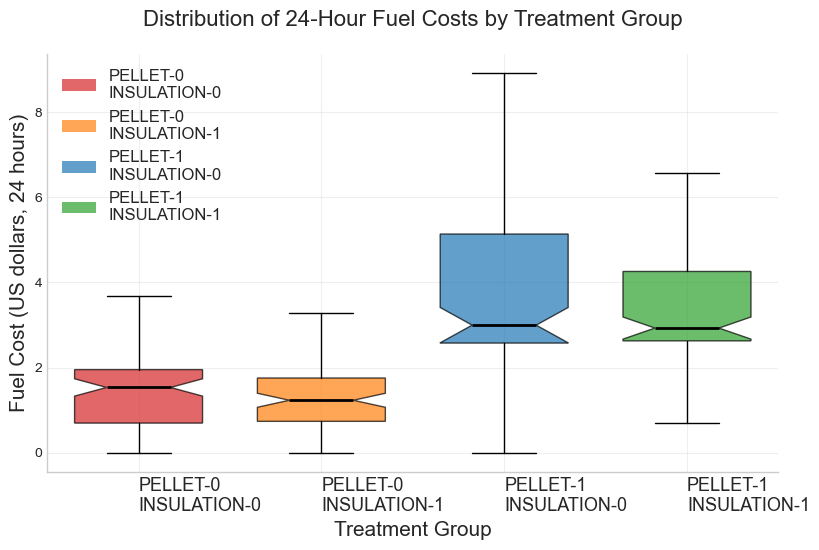


SUMMARY STATISTICS - 24-HOUR FUEL COSTS (USD):
------------------------------------------------------------
PELLET-0
INSULATION-0     | n= 94 | mean=$  1.49 | median=$  1.53 | std=$  1.11 | min=$  0.00 | max=$  5.50
PELLET-0
INSULATION-1     | n= 94 | mean=$  1.34 | median=$  1.23 | std=$  1.00 | min=$  0.00 | max=$  4.74
PELLET-1
INSULATION-0     | n= 94 | mean=$  3.95 | median=$  3.00 | std=$  2.06 | min=$  0.00 | max=$  9.32
PELLET-1
INSULATION-1     | n= 97 | mean=$  3.41 | median=$  2.93 | std=$  1.35 | min=$  0.00 | max=$  7.50

Plot saved as '24hour_fuel_costs_by_treatment_group.png'


In [7]:
# =============================================================================
# 6. CREATE BOXPLOT FOR 24-HOUR FUEL COSTS BY TREATMENT GROUP
# =============================================================================
print("\n" + "="*80)
print("CREATING BOXPLOT FOR 24-HOUR FUEL COSTS")
print("="*80)

import matplotlib.pyplot as plt

# Create 24-hour cost variable in US dollars (divide by 2 for 24h, then by 740 for USD)
df_fuel_clean['Cost24h_USD'] = df_fuel_clean['Cost48h_ave'] / 2 / 740

# Define treatment groups in the order you want them displayed
treatment_groups = ['PELLET-0\\INSULATION-0', 'PELLET-0\\INSULATION-1', 
                   'PELLET-1\\INSULATION-0', 'PELLET-1\\INSULATION-1']

# Create group labels for plotting (with newlines for better readability)
group_labels = ['PELLET-0\nINSULATION-0', 'PELLET-0\nINSULATION-1', 
               'PELLET-1\nINSULATION-0', 'PELLET-1\nINSULATION-1']

# Define colors with good B/W contrast
group_styles = {
    'PELLET-1\nINSULATION-0': {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o'},      # Blue
    'PELLET-0\nINSULATION-1': {'color': '#ff7f0e', 'linestyle': '-', 'marker': 's'},      # Orange 
    'PELLET-1\nINSULATION-1': {'color': '#2ca02c', 'linestyle': '-', 'marker': '^'},      # Green
    'PELLET-0\nINSULATION-0': {'color': '#d62728', 'linestyle': '-', 'marker': 'D'}       # Red
}

# Extract data for each treatment group
data_groups = []
for i, group in enumerate(treatment_groups):
    pellet, insulation = group.split('\\')
    pellet_val = int(pellet.split('-')[1])
    insulation_val = int(insulation.split('-')[1])
    
    mask = (df_fuel_clean['PELLET'] == pellet_val) & (df_fuel_clean['INSULATION'] == insulation_val)
    group_data = df_fuel_clean.loc[mask, 'Cost24h_USD'].dropna()
    data_groups.append(group_data)
    
    print(f"Group {group_labels[i]}: n={len(group_data)}, mean=${group_data.mean():.2f}, std=${group_data.std():.2f}")

# Create the boxplot with 70% size (scale factor 0.7)
fig, ax = plt.subplots(figsize=(12*0.7, 8*0.7))

# Create boxplot
bp = ax.boxplot(data_groups, patch_artist=True, notch=True, showfliers=False, widths=0.7)

# Apply colors to boxes
colors = [group_styles[label]['color'] for label in group_labels]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize other boxplot elements
for cap in bp['caps']:
    cap.set(color='black', linewidth=1)

for median in bp['medians']:
    median.set(color='black', linewidth=2)

for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1, linestyle='-')

# Set labels and titles
ax.set_xticklabels(group_labels, fontsize=13, ha='left')  # This moves labels to left
ax.set_ylabel('Fuel Cost (US dollars, 24 hours)', fontsize=15)
ax.set_xlabel('Treatment Group', fontsize=15)
ax.set_title('Distribution of 24-Hour Fuel Costs by Treatment Group', fontsize=16, pad=20)

# Create custom legend
legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor=group_styles[label]['color'], 
                                alpha=0.7, label=label) for label in group_labels]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.9)

# Add grid and styling
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print(f"\nSUMMARY STATISTICS - 24-HOUR FUEL COSTS (USD):")
print("-" * 60)
for i, (label, data) in enumerate(zip(group_labels, data_groups)):
    if len(data) > 0:
        print(f"{label:25} | n={len(data):3} | mean=${data.mean():6.2f} | "
              f"median=${data.median():6.2f} | std=${data.std():6.2f} | "
              f"min=${data.min():6.2f} | max=${data.max():6.2f}")

# Save the plot
fig.savefig('24hour_fuel_costs_by_treatment_group.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as '24hour_fuel_costs_by_treatment_group.png'")

## New Model: 2×2 Overall Exposure Model. Indoor Air Pollution & Temperature Regardless of Stove Use

This model estimates treatment effects on **aggregate indoor outcomes irrespective of stove ON/OFF**, similar to temperature results (Tables A10–A11) and provides and comparable overall results for air pollution. 

**Equation:**

$$
Y_{it} = \alpha + \delta_1 PELLET_i + \delta_2 INSULATION_i + \delta_3 (PELLET_i \times INSULATION_i)+ \gamma_1 ln(PMo_{it}) + \gamma_2 ln(To_{it}) + \tau_h + \delta_d + u_{it}
$$


**Where:**
- **Y_{it}** → indoor outcome for household *i* at hour *h* on day *t* (either **LnPMi** or **LnTi**),**no stove-use variables included**
- **PELLET** → pellet stove treatment indicator  
- **INSULATION** → insulation treatment indicator  
- **PELLET×INSULATION** → interaction term capturing the joint effect of both technologies
- **LnPM_o** → log of outdoor particulate matter concentration (control for ambient conditions)  
- **LnT_o** → log of outdoor temperature (control for weather conditions)
- **u_{it}** → idiosyncratic error term 

## Interpretation:
Effects are **differences in overall indoor exposure** relative to the baseline **Firewood – No Insulation** group:**Pellet only:** $\delta_1$, **Insulation only:** $\delta_2$  , **Pellet + Insulation:** $\delta_1 + \delta_2 + \delta_3$.

In [ ]:
# Author: Adolfo Uribe
# Date: 10.11.2025

# Pre-treatment of our data

# === Setup ===
import warnings
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress the specific statsmodels warning
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels")

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# =============================================================================
# SETTINGS
# =============================================================================
FILE_PATH = "Panel_03112025.xlsx"
SEED = 42
z_thr = 3.3
hr_thr = 95

# =============================================================================
# 1. DATA LOADING AND CLEANING
# =============================================================================
print("Loading data...")

# Load panel data
df_panel = pd.read_excel(FILE_PATH, sheet_name="Panel")
cols = ['Pmi_cal','Ti','ON','T1','T2','Pmo_cal','To','ID','Hour','DayExp','HRi']
df_pmi = df_panel.dropna(subset=cols).copy()

# Load covariates
df_cov = pd.read_excel(FILE_PATH, sheet_name="Covariates")

# Simple imputation
for col in ['Age', 'Education', 'GenderHHead1women']:
    if col in df_cov.columns:
        if col == 'GenderHHead1women':
            df_cov[col] = df_cov[col].fillna(df_cov[col].mean())
        else:
            df_cov[col] = df_cov[col].fillna(df_cov[col].median())

# =============================================================================
# 2. DATA PREPARATION
# =============================================================================
print("Preparing data...")

# Create variables
df_pmi['PELLET'] = df_pmi['T1']
df_pmi['INSULATION'] = df_pmi['T2']
df_pmi['k_Ti'] = df_pmi['Ti'] + 273
df_pmi['k_To'] = df_pmi['To'] + 273

# Create logs (ensure positive values)
df_pmi = df_pmi[df_pmi['Pmo_cal'] > 0].copy()
df_pmi = df_pmi[df_pmi['Pmi_cal'] > 0].copy()

df_pmi['LnPMi'] = np.log(df_pmi['Pmi_cal'])
df_pmi['LnPMo'] = np.log(df_pmi['Pmo_cal'])
df_pmi['LnTi'] = np.log(df_pmi['k_Ti'])
df_pmi['LnTo'] = np.log(df_pmi['k_To'])


# User settings
# -----------------------
FILE_PATH       = "Panel_03112025.xlsx"
SHEET_NAME      = "Covariates"
SEED            = 42  # reproducible imputation for gender
# -----------------------
# 0) Load data
# -----------------------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
df_imputed = df.copy()
# Track which rows were imputed (booleans)
df_imputed["imputed_Age"]       = False
df_imputed["imputed_Education"] = False
df_imputed["imputed_Gender"]    = False
# =======================
# 1) AGE: median within Anypersonolder60 groups (0/1)
# =======================
#print("\n=== AGE IMPUTATION ===")
age_medians = df_imputed.groupby("Anypersonolder60", dropna=False)["Age"].median()
#print("Median Age by Anypersonolder60:")
#print(age_medians, "\n")
for g, med in age_medians.items():
    mask = (df_imputed["Anypersonolder60"] == g) & (df_imputed["Age"].isna())
    df_imputed.loc[mask, "Age"] = med
    df_imputed.loc[mask, "imputed_Age"] = True
#print(f"✅ Remaining missing Ages: {df_imputed['Age'].isna().sum()}")
# =======================
# 2) EDUCATION: overall sample median (no grouping)
# =======================
#print("\n=== EDUCATION IMPUTATION ===")
edu_median_all = df_imputed["Education"].median()
#print(f"Overall median Education (full sample): {edu_median_all}\n")
mask_edu_miss = df_imputed["Education"].isna()
df_imputed.loc[mask_edu_miss, "Education"] = edu_median_all
df_imputed.loc[mask_edu_miss, "imputed_Education"] = True
#print(f"✅ Remaining missing Education values: {df_imputed['Education'].isna().sum()}")
# (Optional) If you want Education as integers, uncomment:
# df_imputed["Education"] = df_imputed["Education"].round().astype("Int64")
# =======================
# 3) GENDER: random draw using observed proportion of women (among non-missing)
# =======================
#print("\n=== GENDER IMPUTATION ===")
prop_women = df_imputed["GenderHHead1women"].mean(skipna=True)
#print(f"Observed share of women heads: {prop_women:.2%}")
mask_gender_miss = df_imputed["GenderHHead1women"].isna()
n_miss_gender = mask_gender_miss.sum()
#print(f"Missing GenderHHead1women values: {n_miss_gender}")
np.random.seed(SEED)
if n_miss_gender > 0:
    draws = np.random.binomial(1, prop_women, size=n_miss_gender)
    df_imputed.loc[mask_gender_miss, "GenderHHead1women"] = draws
    df_imputed.loc[mask_gender_miss, "imputed_Gender"] = True
#print(f"✅ Imputed {n_miss_gender} Gender values by random draws (p={prop_women:.3f}).")
#print("New share of women heads:",df_imputed["GenderHHead1women"].mean().round(3))
# =======================
# 4) Compact audit report
# =======================
print("\n=== IMPUTATION AUDIT SUMMARY ===")
audit = {
    "Age": {
        "imputed_n": int(df_imputed["imputed_Age"].sum()),
        "remaining_na": int(df_imputed["Age"].isna().sum())
    },
    "Education": {
        "imputed_n": int(df_imputed["imputed_Education"].sum()),
        "remaining_na": int(df_imputed["Education"].isna().sum())
    },
    "GenderHHead1women": {
        "imputed_n": int(df_imputed["imputed_Gender"].sum()),
        "remaining_na": int(df_imputed["GenderHHead1women"].isna().sum())
    }
}
for k, v in audit.items():
    print(f"{k:>18} → imputed: {v['imputed_n']:>3}, remaining NA: {v['remaining_na']:>3}")
# -----------------------
# (Optional) save result
# -----------------------
# df_imputed.to_excel("Covariates_imputed.xlsx", index=False)

interaction_pairs = [
    ("FamilySize", "Chamber"),              # People × facility
    ("FamilySize", "Perc_concrete_built"),  # People × building
    ("Chamber", "Perc_concrete_built"),     # Facility × building quality
    ("Anypersonolder60", "Perc_concrete_built"),  # Elderly × housing adaptation
]

# =============================================================================
# OVERALL TREATMENT EFFECTS MODEL - NO STOVE USAGE VARIABLES
# =============================================================================

def run_overall_treatment_analysis(outcome_var, use_matching=False):
    """Run overall treatment effects model without stove usage variables"""
    
    # Prepare data
    if use_matching:
        # Use matched sample (you'll need to implement matching first)
        df_analysis = get_matched_sample()  # You'll need to define this
        model_name = "With_Matching"
    else:
        df_analysis = df_pmi.copy()
        model_name = "No_Matching"
    
    model_cols = [outcome_var, 'PELLET', 'INSULATION', 'LnPMo', 'LnTo', 'Hour', 'DayExp']
    df_analysis = df_analysis.dropna(subset=model_cols).copy()
    
    for fe in ['Hour', 'DayExp']:
        df_analysis[fe] = df_analysis[fe].astype('category')

    # Model specification: Only treatments and their interaction (no stove usage variables)
    formula = (
        f"{outcome_var} ~ PELLET + INSULATION + PELLET:INSULATION + "
        f"LnPMo + LnTo + C(Hour) + C(DayExp)"
    )
    
    model = smf.ols(formula, data=df_analysis).fit(
        cov_type='cluster', cov_kwds={'groups': df_analysis['ID']}
    )

    # Display results
    print(f"\n{'='*80}")
    print(f"OVERALL TREATMENT EFFECTS: {outcome_var} ({model_name})")
    print(f"{'='*80}")
    print(f"Observations: {int(model.nobs):,}")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Fixed effects: C(Hour), C(DayExp)")
    print(f"No stove usage variables (ON, ON_Second)")
    
    # Show all coefficients (excluding FE dummies)
    all_terms = ['Intercept', 'PELLET', 'INSULATION', 'PELLET:INSULATION', 'LnPMo', 'LnTo']
    available_terms = [t for t in all_terms if t in model.params.index]
    
    coef_df = pd.DataFrame({
        'Coef.': model.params[available_terms],
        'Std.Err': model.bse[available_terms],
        't': model.tvalues[available_terms],
        'P>|t|': model.pvalues[available_terms]
    }).round(4)
    
    print("\nMain coefficients (Hour and DayExp FE suppressed):")
    print(coef_df)
    
    # Calculate treatment combinations
    print(f"\nTREATMENT COMBINATIONS for {outcome_var}:")
    params = model.params
    vcov = model.cov_params()
    
    # Define treatment combinations
    combinations = {
        'Pellet only': ['PELLET'],
        'Insulation only': ['INSULATION'], 
        'Pellet + Insulation': ['PELLET', 'INSULATION', 'PELLET:INSULATION']
    }
    
    for name, terms in combinations.items():
        # Check if all terms are available
        if all(t in params.index for t in terms):
            effect = sum(params[t] for t in terms)
            # Calculate SE for the combination
            var_terms = [t for t in terms if t in vcov.index]
            if len(var_terms) > 0:
                se = np.sqrt(vcov.loc[var_terms, var_terms].sum().sum())
                t_stat = effect / se
                p_value = 2 * (1 - st.t.cdf(abs(t_stat), df=model.df_resid))
                
                # For LnPMi, calculate % change; for LnTi, keep as log points
                if outcome_var == 'LnPMi':
                    pct_change = 100 * (np.exp(effect) - 1)
                    print(f"  {name}: {effect:.4f} (SE: {se:.4f}, p={p_value:.4f}) → {pct_change:+.1f}%")
                else:
                    print(f"  {name}: {effect:.4f} (SE: {se:.4f}, p={p_value:.4f})")
    
    # Save results
    coef_df['Model'] = f'Overall_Treatment_{model_name}'
    coef_df['N'] = int(model.nobs)
    coef_df['R2'] = model.rsquared
    coef_df.to_csv(f'overall_treatment_{outcome_var}_{model_name}.csv', index=True)
    
    return model


print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
# =============================================================================
# OVERALL TREATMENT EFFECTS MODEL WITH MATCHING - NO STOVE USAGE VARIABLES
# =============================================================================

def run_overall_treatment_analysis_with_matching(outcome_var):
    """Run overall treatment effects model with matching"""
    
    print(f"\nPreparing matched sample for {outcome_var} analysis...")
    
    # 1) Create treatment groups for matching
    id_t = (
        df_pmi[["ID","PELLET","INSULATION"]]
        .drop_duplicates(subset=["ID"])
        .copy()
    )

    id_t["Group"] = (
        id_t["PELLET"].astype(int).astype(str) + id_t["INSULATION"].astype(int).astype(str)
    )
    group_map = {"00":0, "10":1, "01":2, "11":3}
    id_t["Group"] = id_t["Group"].map(group_map).astype(int)

    # 2) Merge covariates for matching
    base_covs = ["FamilySize", "Chamber", "Perc_concrete_built", "Age", "Education"]
    cov_need = ["ID"] + base_covs

    gps_df = id_t.merge(df_imputed[cov_need], on="ID", how="left").copy()
    
    # Handle missing values
    for c in base_covs:
        if gps_df[c].isna().any():
            gps_df[c] = gps_df[c].fillna(gps_df[c].median())

    # 3) Multinomial propensity score matching
    print(f"Fitting multinomial logit for matching...")
    X = gps_df[base_covs].copy()
    y = gps_df["Group"].astype(int)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    mlogit = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
    mlogit.fit(X_scaled, y)
    probs = mlogit.predict_proba(X_scaled)

    # 4) Calculate stabilized weights
    pi = gps_df["Group"].value_counts(normalize=True).sort_index().reindex([0,1,2,3]).values
    p_hat = probs[np.arange(len(gps_df)), y.values]
    sw = pi[y.values] / p_hat

    gps_df["weight_gps"] = sw

    # Trimming weights
    lo, hi = np.percentile(gps_df["weight_gps"], [1, 99])
    gps_df["weight_gps"] = gps_df["weight_gps"].clip(lower=lo, upper=hi)

    print("GPS weights summary:")
    print(gps_df["weight_gps"].describe())

    # 5) Merge weights back to panel data
    df_pmi_w = df_pmi.merge(gps_df[["ID","weight_gps"]], on="ID", how="inner").copy()
    
    # 6) Run weighted regression
    model_cols = [outcome_var, 'PELLET', 'INSULATION', 'LnPMo', 'LnTo', 'Hour', 'DayExp', 'weight_gps']
    df_analysis = df_pmi_w.dropna(subset=model_cols).copy()
    
    for fe in ['Hour', 'DayExp']:
        df_analysis[fe] = df_analysis[fe].astype('category')

    # Model specification with matching weights
    formula = (
        f"{outcome_var} ~ PELLET + INSULATION + PELLET:INSULATION + "
        f"LnPMo + LnTo + C(Hour) + C(DayExp)"
    )
    
    model = smf.wls(formula, data=df_analysis, weights=df_analysis["weight_gps"]).fit(
        cov_type='cluster', cov_kwds={'groups': df_analysis['ID']}
    )

    # Display results
    print(f"\n{'='*80}")
    print(f"OVERALL TREATMENT EFFECTS WITH MATCHING: {outcome_var}")
    print(f"{'='*80}")
    print(f"Observations: {int(model.nobs):,}")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Fixed effects: C(Hour), C(DayExp)")
    print(f"Propensity score matching: YES")
    
    # Show all coefficients (excluding FE dummies)
    all_terms = ['Intercept', 'PELLET', 'INSULATION', 'PELLET:INSULATION', 'LnPMo', 'LnTo']
    available_terms = [t for t in all_terms if t in model.params.index]
    
    coef_df = pd.DataFrame({
        'Coef.': model.params[available_terms],
        'Std.Err': model.bse[available_terms],
        't': model.tvalues[available_terms],
        'P>|t|': model.pvalues[available_terms]
    }).round(4)
    
    print("\nMain coefficients (Hour and DayExp FE suppressed):")
    print(coef_df)
    
    # Calculate treatment combinations
    print(f"\nTREATMENT COMBINATIONS for {outcome_var} (WITH MATCHING):")
    params = model.params
    vcov = model.cov_params()
    
    # Define treatment combinations
    combinations = {
        'Pellet only': ['PELLET'],
        'Insulation only': ['INSULATION'], 
        'Pellet + Insulation': ['PELLET', 'INSULATION', 'PELLET:INSULATION']
    }
    
    for name, terms in combinations.items():
        # Check if all terms are available
        if all(t in params.index for t in terms):
            effect = sum(params[t] for t in terms)
            # Calculate SE for the combination
            var_terms = [t for t in terms if t in vcov.index]
            if len(var_terms) > 0:
                se = np.sqrt(vcov.loc[var_terms, var_terms].sum().sum())
                t_stat = effect / se
                p_value = 2 * (1 - st.t.cdf(abs(t_stat), df=model.df_resid))
                
                # For LnPMi, calculate % change; for LnTi, keep as log points
                if outcome_var == 'LnPMi':
                    pct_change = 100 * (np.exp(effect) - 1)
                    print(f"  {name}: {effect:.4f} (SE: {se:.4f}, p={p_value:.4f}) → {pct_change:+.1f}%")
                else:
                    print(f"  {name}: {effect:.4f} (SE: {se:.4f}, p={p_value:.4f})")
    
    # Save results
    coef_df['Model'] = 'Overall_Treatment_With_Matching'
    coef_df['N'] = int(model.nobs)
    coef_df['R2'] = model.rsquared
    coef_df.to_csv(f'overall_treatment_{outcome_var}_with_matching.csv', index=True)
    
    return model





# Analysis 1A: Overall treatment effects on LnPMi (air pollution)
#print("\n" + "="*80)
#print("ANALYSIS 1A: OVERALL TREATMENT EFFECTS ON INDOOR AIR POLLUTION (LnPMi)")
#print("="*80)
treatment_pmi = run_overall_treatment_analysis('LnPMi', use_matching=False)


# Analysis 1B: Overall treatment effects on LnPMi (air pollution) with matching
#print("\n" + "="*80)
#print("ANALYSIS 1B: OVERALL TREATMENT EFFECTS ON INDOOR AIR POLLUTION (LnPMi) - WITH MATCHING")
#print("="*80)
treatment_pmi_matched = run_overall_treatment_analysis_with_matching('LnPMi')


# Analysis 2A: Overall treatment effects on LnTi (indoor temperature)  
#print("\n" + "="*80)
#print("ANALYSIS 2A: OVERALL TREATMENT EFFECTS ON INDOOR TEMPERATURE (LnTi)")
#print("="*80)
treatment_ti = run_overall_treatment_analysis('LnTi', use_matching=False)

# Analysis 2B: Overall treatment effects on LnTi (indoor temperature) with matching
#print("\n" + "="*80)
#print("ANALYSIS 2B: OVERALL TREATMENT EFFECTS ON INDOOR TEMPERATURE (LnTi) - WITH MATCHING")
#print("="*80)
treatment_ti_matched = run_overall_treatment_analysis_with_matching('LnTi')


# =============================================================================
# COMPREHENSIVE TREATMENT EFFECTS WITH PROPER STANDARD ERRORS
# =============================================================================

def lincom_sum(model, terms):
    """
    Compute linear combination b = sum(beta_j for j in terms),
    its standard error from the clustered covariance, and inference.
    """
    # Guard: ensure all requested terms are in the model
    missing = [t for t in terms if t not in model.params.index]
    if missing:
        raise KeyError(f"These terms are missing in the fitted model: {missing}")

    # Point estimate
    b = model.params.loc[terms].sum()

    # Variance of the sum: 1' * Cov[terms,terms] * 1
    V = model.cov_params().loc[terms, terms].values
    se = float(np.sqrt(V.sum()))  # since weights are all 1

    # Inference with model degrees of freedom
    df = int(model.df_resid)
    tval = b / se if se > 0 else np.nan
    pval = 2 * (1 - st.t.cdf(abs(tval), df=df)) if se > 0 else np.nan

    # 95% CI
    tcrit = st.t.ppf(0.975, df=df)
    ci_lo, ci_hi = b - tcrit * se, b + tcrit * se

    return {
        "Effect (beta)": b,
        "Std. Error": se,
        "t": tval,
        "p>|t|": pval,
        "CI95 Low": ci_lo,
        "CI95 High": ci_hi
    }

def print_treatment_effects_table(model, outcome_var, model_name):
    """Print comprehensive treatment effects table for all 4 groups"""
    
    # Define the four treatment groups as linear combinations
    groups = {
        "Firewood – No Insulation": [],  # Reference group (all coefficients = 0)
        "Pellet only": ["PELLET"],
        "Insulation only": ["INSULATION"],
        "Pellet + Insulation": ["PELLET", "INSULATION", "PELLET:INSULATION"],
    }
    
    # Compute and present results
    rows = []
    for label, terms in groups.items():
        if terms:  # For non-reference groups
            res = lincom_sum(model, terms)
        else:  # For reference group (all zeros)
            res = {
                "Effect (beta)": 0.0,
                "Std. Error": 0.0,
                "t": np.nan,
                "p>|t|": np.nan,
                "CI95 Low": 0.0,
                "CI95 High": 0.0
            }
        
        res["Group"] = label
        res["Expression"] = " + ".join(terms) if terms else "Reference"
        
        # Calculate percentage change for LnPMi
        if outcome_var == 'LnPMi':
            pct = 100 * (np.exp(res["Effect (beta)"]) - 1)
            pct_lo = 100 * (np.exp(res["CI95 Low"]) - 1)
            pct_hi = 100 * (np.exp(res["CI95 High"]) - 1)
            res["% Change"] = pct
            res["%CI95 Low"] = pct_lo
            res["%CI95 High"] = pct_hi
        else:
            # For temperature, just show the effect size
            res["Effect Size"] = res["Effect (beta)"]
            res["CI95 Low"] = res["CI95 Low"]
            res["CI95 High"] = res["CI95 High"]
        
        rows.append(res)
    
    effects_df = (
        pd.DataFrame(rows)
        .set_index("Group")
        .loc[list(groups.keys()), :]  # keep defined order
    )
    
    # Format the table based on outcome variable
    print(f"\n{'='*90}")
    print(f"COMPREHENSIVE TREATMENT EFFECTS ON {outcome_var.upper()} ({model_name})")
    print(f"{'='*90}")
    
    if outcome_var == 'LnPMi':
        # Format for PM (show percentage changes)
        display_df = effects_df.round({
            "Effect (beta)": 4, "Std. Error": 4, "t": 2, "p>|t|": 4,
            "CI95 Low": 4, "CI95 High": 4, "% Change": 1, "%CI95 Low": 1, "%CI95 High": 1
        })
        
        display_cols = [
            "Expression", "Effect (beta)", "Std. Error", "t", "p>|t|",
            "CI95 Low", "CI95 High", "% Change", "%CI95 Low", "%CI95 High"
        ]
    else:
        # Format for temperature (show effect sizes)
        display_df = effects_df.round({
            "Effect (beta)": 4, "Std. Error": 4, "t": 2, "p>|t|": 4,
            "CI95 Low": 4, "CI95 High": 4
        })
        display_df = display_df.rename(columns={
            "Effect (beta)": "Effect Size",
            "CI95 Low": "CI95 Low", 
            "CI95 High": "CI95 High"
        })
        
        display_cols = [
            "Expression", "Effect Size", "Std. Error", "t", "p>|t|",
            "CI95 Low", "CI95 High"
        ]
    
    print(display_df[display_cols].to_string())
    
    return effects_df

# =============================================================================
# RUN COMPREHENSIVE ANALYSIS FOR ALL MODELS
# =============================================================================

#print("\n" + "="*90)
#print("COMPREHENSIVE TREATMENT EFFECTS ANALYSIS WITH PROPER STANDARD ERRORS")
#print("="*90)

# Analysis 1A: LnPMi without matching
print("\n" + "="*90)
print("ANALYSIS 1A: COMPREHENSIVE EFFECTS ON INDOOR AIR POLLUTION (LnPMi)")
print("="*90)
effects_pmi_no_match = print_treatment_effects_table(treatment_pmi, 'LnPMi', 'No Matching')

# Analysis 1B: LnPMi with matching
print("\n" + "="*90)
print("ANALYSIS 1B: COMPREHENSIVE EFFECTS ON INDOOR AIR POLLUTION (LnPMi) - WITH MATCHING")
print("="*90)
effects_pmi_match = print_treatment_effects_table(treatment_pmi_matched, 'LnPMi', 'With Matching')

# Analysis 2A: LnTi without matching
print("\n" + "="*90)
print("ANALYSIS 2A: COMPREHENSIVE EFFECTS ON INDOOR TEMPERATURE (LnTi)")
print("="*90)
effects_ti_no_match = print_treatment_effects_table(treatment_ti, 'LnTi', 'No Matching')

# Analysis 2B: LnTi with matching
print("\n" + "="*90)
print("ANALYSIS 2B: COMPREHENSIVE EFFECTS ON INDOOR TEMPERATURE (LnTi) - WITH MATCHING")
print("="*90)
effects_ti_match = print_treatment_effects_table(treatment_ti_matched, 'LnTi', 'With Matching')

# Save all results
effects_pmi_no_match['Model'] = 'No_Matching'
effects_pmi_no_match['Outcome'] = 'LnPMi'
effects_pmi_match['Model'] = 'With_Matching' 
effects_pmi_match['Outcome'] = 'LnPMi'
effects_ti_no_match['Model'] = 'No_Matching'
effects_ti_no_match['Outcome'] = 'LnTi'
effects_ti_match['Model'] = 'With_Matching'
effects_ti_match['Outcome'] = 'LnTi'

# Combine and save
all_effects = pd.concat([
    effects_pmi_no_match.reset_index(),
    effects_pmi_match.reset_index(),
    effects_ti_no_match.reset_index(),
    effects_ti_match.reset_index()
], ignore_index=True)

all_effects.to_csv('comprehensive_treatment_effects_all_models.csv', index=False)

print("\n" + "="*90)
print("ANALYSIS COMPLETED!")
print("="*90)
print("✓ Comprehensive treatment effects computed for all 4 groups")
print("✓ Proper standard errors and confidence intervals calculated")
print("✓ Results saved to: comprehensive_treatment_effects_all_models.csv")
print("✓ Tables show effects relative to Firewood – No Insulation (reference group)")

Loading data...
